# International Trade Network Analysis: Understanding Global Economic Interactions

International trade forms the backbone of the global economy, facilitating the exchange of goods, services, and resources between countries. The intricate web of trade relationships not only impacts national economies but also influences global economic stability and growth. Understanding these relationships is crucial for policymakers, economists, and business leaders alike. In this context, network analysis provides a powerful tool to unravel the complexities of international trade.

International trade networks are dynamic and complex. By analyzing these networks, we can uncover patterns, trends, and key players that shape global trade. Through centrality measures we can identify countries that play a central role in the trade network. These central countries often act as major hubs, influencing trade flows and economic policies.

In [1]:
import json
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import csv

In [2]:
with open(r'C:\Users\the_s\Desktop\AI Master\Social Network Analysis\countries.json', 'r') as file:
    data = json.load(file)

## Utils

In [4]:
# Function to format GDP values
def format_gdp(gdp_value):
    try:
        if 'trillion' in gdp_value:
            return float(gdp_value.replace('$', '').replace(' trillion', '').replace(',', ''))
        elif 'billion' in gdp_value:
            return float(gdp_value.replace('$', '').replace(' billion', '').replace(',', '')) / 1000
        elif 'million' in gdp_value:
            return float(gdp_value.replace('$', '').replace(' million', '').replace(',', '')) / 1_000_000
        else:
            return None
    except ValueError:
        return None

def create_df(data, country_mapping, partners_str, commodities_str, include_exports_attributes=False, include_imports_attributes=False):
    partner_data = []
    node_attributes = {}
    
    for country, country_data in data.items():
        partners = country_data.get(partners_str, {})
        commodities = country_data.get(commodities_str, '')
        
        # Apply country mapping to country name
        if country in country_mapping:
            country_mapped = country_mapping[country]
        else:
            country_mapped = country
        
        # Extract GDP values based on the specified attributes
        gdp = format_gdp(country_data.get('GDP', ''))
        exports_money = format_gdp(country_data.get('Exports $', ''))
        imports_money = format_gdp(country_data.get('Imports $', ''))
        exports_gdp = country_data.get('GDP% Exports', '')
        imports_gdp = country_data.get('GDP% Imports', '')
        
        # Populate node attributes based on the specified graph type
        if include_exports_attributes:
            node_attributes[country_mapped] = {
                'GDP': gdp,
                'Exports $': exports_money,
                'Exports GDP%': exports_gdp,
                'Commodities': [commodity.strip() for commodity in commodities.split(',')]
            }
        elif include_imports_attributes:
            node_attributes[country_mapped] = {
                'GDP': gdp,
                'Imports GDP%': imports_gdp,
                'Imports $': imports_money,
                'Commodities': [commodity.strip() for commodity in commodities.split(',')]
            }
        
        for partner, weight in partners.items():
            if partner in country_mapping:
                partner_mapped = country_mapping[partner]
            else:
                partner_mapped = partner
            
            partner_data.append({
                'source': country_mapped,
                'target': partner_mapped,
                'weight': float(weight)
            })
    
    df = pd.DataFrame(partner_data)
    return df, node_attributes

def create_graph(df, node_attributes):
    G = nx.DiGraph()
    
    # Add edges
    for _, row in df.iterrows():
        G.add_edge(row['source'], row['target'], weight=row['weight'])
    
    # Add node attributes
    for node, attributes in node_attributes.items():
        G.nodes[node].update(attributes)
    
    return G
    
def plot_attributes(data_dict, title, xlabel, ylabel, color='skyblue'):
    # Sort the data by country names (keys)
    sorted_items = sorted(data_dict.items())
    sorted_countries = [item[0] for item in sorted_items]
    sorted_values = [item[1] for item in sorted_items]
    
    plt.figure(figsize=(28, 7))
    plt.bar(sorted_countries, sorted_values, color=color, edgecolor='black')
    plt.xticks(rotation=90, fontsize=6)
    plt.title(title, fontsize=15)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.show()

# Extract data for histograms
def extract_node_attributes(graph, attribute):
    return {node: data.get(attribute, 0) for node, data in graph.nodes(data=True)}


# Plot Centrality Histogram
def centrality(cent, type, threshold, color='skyblue'):
    # Sort countries and their centrality values alphabetically by country names
    sorted_items = sorted(cent.items())
    sorted_countries = [item[0] for item in sorted_items]
    sorted_centrality_values = [item[1] for item in sorted_items]
    
    plt.figure(figsize=(28, 7))
    plt.bar(sorted_countries, sorted_centrality_values, color=color, edgecolor='black')
    plt.xticks(rotation=90, fontsize=6)
    plt.title(type+' of Nodes', fontsize=15)
    plt.xlabel('Country', fontsize=12)
    plt.ylabel(type, fontsize=12)
    plt.show()

    # Find nodes with high centrality
    high_centrality_nodes = {node: centrality for node, centrality in cent.items() if centrality > threshold}

    # Sort high centrality nodes by their centrality values in descending order
    sorted_high_centrality_nodes = sorted(high_centrality_nodes.items(), key=lambda item: item[1], reverse=True)

    print('Nodes (Countries) with High '+type+' (> '+str(threshold)+'):')
    for node, centrality in sorted_high_centrality_nodes:
        print(f"{node}: {centrality:.4f}")
    
    return dict(sorted_high_centrality_nodes)


# Plot Centrality Power Law
def plot_centrality_power_law(centrality_values, G, bins, type, color):
    
    # Calculate histogram
    freq, bins = np.histogram(centrality_values, bins=bins)
    
    # Calculate bin centers
    x = (bins[:-1] + bins[1:]) / 2  # x = center value of each bin
    y = freq  # y = occurrence
    
    # Filter out zero values
    non_zero_indices = np.where(y > 0)
    x_display = x[non_zero_indices]
    y_display = y[non_zero_indices]
    
    # Exclude the last value for the fit (if it's an outlier)
    fit_points = np.where(x_display < np.max(x_display))
    x_fit = x_display[fit_points]
    y_fit = y_display[fit_points]
    
    # Take the logarithm of x and y
    log_x_display = np.log10(x_display)
    log_y_display = np.log10(y_display)
    log_x_fit = np.log10(x_fit)
    log_y_fit = np.log10(y_fit)
    
    # Fit a straight line to the data
    coeffs = np.polyfit(log_x_fit, log_y_fit, 1)
    
    # Generate y-values for the fitted line
    fitted_y = coeffs[0] * log_x_fit + coeffs[1]
    
    # Perform linear regression and get p-value
    slope, intercept, r_value, p_value, std_err = stats.linregress(log_x_fit, log_y_fit)
    
    # Plot the data and the fit
    plt.figure(figsize=(8, 5))
    plt.scatter(log_x_display, log_y_display, color='r', label='Data')
    plt.plot(log_x_fit, fitted_y, color, label='Best fit line')  # Plot fitted line
    plt.legend()
    plt.xlabel('Log '+type+' Centrality')
    plt.ylabel('Log Frequency')
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    plt.text(min(log_x_display), max(log_y_display), f'p-value: {p_value:.1e} \nR: {r_value:.2f}', bbox=dict(facecolor='white')) # Add p-value to the plot
    
    plt.show()
    
    print(f"The slope of the line is: {slope}")
    return slope

# Plot Cumulative Distribution Graph
def cumulative_distribution(centrality_values,type,color, save=False):
    # Sort the degree centrality values
    sorted_centrality_values = np.sort(centrality_values)
    
    # Cumulative distribution
    cdf = np.arange(1, len(sorted_centrality_values) + 1) / len(sorted_centrality_values)
    
    # CDF Plot
    plt.figure(figsize=(20, 6))
    
    # Linear scale plot
    plt.subplot(1, 2, 1)
    plt.plot(sorted_centrality_values, cdf, color=color)
    plt.xlabel(type+' Centrality')
    plt.ylabel('Cumulative Frequency')
    plt.title(type+' Centrality Cumulative Distribution')
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    
    # Log-log scale plot
    plt.subplot(1, 2, 2)
    plt.plot(sorted_centrality_values, cdf, color=color)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(type+' Centrality')
    plt.ylabel('Cumulative Frequency')
    plt.title(type+' Centrality Cumulative Distribution (log-log plot)')
    plt.grid(True, which="both", ls="--", linewidth=0.5)

    if save:
        plt.savefig(type+'_'+color+'.png')
        
    plt.show()

# Pearson correlation coefficient
def correlation_cd(clustering_coeffs_values, degree_centrality_values, color='skyblue'):
    correlation, p_value = stats.pearsonr(clustering_coeffs_values, degree_centrality_values)
    
    print(f"Pearson correlation coefficient: {correlation:.4f}")
    print(f"P-value: {p_value:.4e}")
    
    # Plotting the correlation
    plt.figure(figsize=(10, 6))
    plt.scatter(degree_centrality_values, clustering_coeffs_values, color=color, alpha=0.6)
    plt.xlabel('Degree Centrality')
    plt.ylabel('Local Clustering Coefficient')
    plt.title(f'Correlation between Degree Centrality and Local Clustering Coefficient\nPearson r = {correlation:.4f}')
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    plt.show()
    return correlation, p_value


# K-cores
def kcores(G_noloops, a, b):
    k_values = range(a, b)  # Define the k values
    
    for k in k_values:
        k_core_subgraph = nx.k_core(G_noloops, k)
        k_core_nodes = k_core_subgraph.nodes()
        if len(k_core_nodes) > 0:  # Only print non-empty k-cores
            print(f"\nNodes in the {k}-core:", k_core_nodes)
    return k_core_nodes


# Plot the Degree Correlation
def deg_cor(G, color='skyblue'):
    # Compute the degree of each node
    degree = dict(G.degree())
    
    # Compute the average neighbor degree for each node
    avg_neighbor_degree = nx.average_neighbor_degree(G)
    
    # Prepare data for plotting
    degrees = list(degree.values())
    avg_neighbor_degrees = [avg_neighbor_degree[node] for node in G.nodes()]
    
    # Scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(degrees, avg_neighbor_degrees, color=color, alpha=0.6)
    plt.xlabel('Node Degree')
    plt.ylabel('Average Neighbor Degree')
    plt.title('Degree Correlation')
    plt.grid(True)
    plt.show()

## Data Preprocessing

In [6]:
key_mapping = {
        "Economy: Real GDP (purchasing power parity)": "GDP",
        "Economy: GDP - composition, by end use - exports of goods and services": "GDP% Exports",
        "Economy: GDP - composition, by end use - imports of goods and services": "GDP% Imports",
        "Economy: Exports": "Exports $",
        "Economy: Exports - partners": "Export Partners",
        "Economy: Exports - commodities": "Export Commodities",
        "Economy: Imports": "Imports $",
        "Economy: Imports - partners": "Import Partners",
        "Economy: Imports - commodities": "Import Commodities"
    }
old_keys = list(key_mapping.keys())

data = {country: data[country] for country in data if all(key in data[country] for key in old_keys)}

In [7]:
for country, country_data in data.items():
        filtered_renamed_data = {key_mapping.get(key, key): value for key, value in country_data.items() if key in old_keys}
        data[country] = filtered_renamed_data

for country_data in data.values():
    for key, value in country_data.items():
        tempval = value.split(' (')[0]
        country_data[key] = tempval.strip('%')
        
for country_data in data.values():
    export_partners_str = country_data['Export Partners']
    export_partners = export_partners_str.split(', ')

    export_partner_associations = {}

    for partner_str in export_partners:
        last_space_index = partner_str.rfind(' ')
        partner = partner_str[:last_space_index]
        percentage = partner_str[last_space_index+1:]
        percentage = percentage.replace(',', '')
        percentage = percentage.replace('%', '')

        export_partner_associations[partner] = percentage
        
    country_data['Export Partners'] = export_partner_associations

    import_partners_str = country_data['Import Partners']
    import_partners = import_partners_str.split(', ')

    import_partner_associations = {}

    for partner_str in import_partners:
        last_space_index = partner_str.rfind(' ')
        partner = partner_str[:last_space_index]
        percentage = partner_str[last_space_index+1:]
        percentage = percentage.replace(',', '')
        percentage = percentage.replace('%', '')

        import_partner_associations[partner] = percentage

    country_data['Import Partners'] = import_partner_associations

In [8]:
print(data['United States'])

{'GDP': '$21.538 trillion', 'GDP% Exports': '12.1', 'GDP% Imports': '-15', 'Exports $': '$3.018 trillion', 'Export Partners': {'Canada': '16', 'Mexico': '15', 'China': '9', 'Japan': '4', 'South Korea': '4'}, 'Export Commodities': 'refined petroleum, natural gas, crude petroleum, cars and vehicle parts, integrated circuits, aircraft, vaccines and cultures', 'Imports $': '$3.97 trillion', 'Import Partners': {'China': '19', 'Mexico': '13', 'Canada': '13', 'Germany': '5', 'Japan': '5'}, 'Import Commodities': 'cars, crude petroleum, computers, broadcasting equipment, packaged medicines'}


In [9]:
country_mapping = {
    'UK': 'United Kingdom',
    'US': 'United States',
    'UAE': 'United Arab Emirates',
    'Gambia, The': 'Gambia',
    'Turkey (Turkiye)': 'Turkey',
    'Congo, Democratic Republic of the': 'Congo',
    'Democratic Republic of the Congo': 'Congo',
    'Congo, Republic of the': 'Congo',
    'Republic of the Congo': 'Congo',
    'Korea, South': 'South Korea',
    'Korea, North': 'North Korea',
    'Cost Rica': 'Costa Rica',
    'NZ': 'New Zealand',
    'Micronesia, Federated States of': 'Micronesia',
    'Bahamas, The': 'Bahamas'
}

### Dataframes Creation

In [11]:
# Create exports dataframe and node attributes
exports_df, export_node_attributes = create_df(data, country_mapping, 'Export Partners', 'Export Commodities', include_exports_attributes=True)
exports_df

,source,target,weight
0,Afghanistan,United Arab Emirates,45.0
1,Afghanistan,Pakistan,24.0
2,Afghanistan,India,22.0
3,Afghanistan,China,1.0
4,Albania,Italy,45.0
...,...,...,...
971,Zambia,Congo,9.0
972,Zambia,Singapore,8.0
973,Zimbabwe,United Arab Emirates,40.0
974,Zimbabwe,South Africa,23.0


In [12]:
# Imports df
imports_df, import_node_attributes = create_df(data, country_mapping, 'Import Partners', 'Import Commodities', include_imports_attributes=True)
imports_df

,source,target,weight
0,Afghanistan,United Arab Emirates,23.0
1,Afghanistan,Pakistan,17.0
2,Afghanistan,India,13.0
3,Afghanistan,Uzbekistan,7.0
4,Afghanistan,China,9.0
...,...,...,...
1000,Zambia,Congo,6.0
1001,Zambia,India,5.0
1002,Zimbabwe,South Africa,41.0
1003,Zimbabwe,Singapore,23.0


## Networks

Analyzing both import and export networks separately allows us to understand the different roles countries play in global trade. Some countries might be central in the export network but peripheral in the import network, and vice versa.

In [15]:
G_exports = create_graph(exports_df, export_node_attributes)

# Check number of nodes
num_nodes_export = G_exports.number_of_nodes()
print(f"Number of nodes in export graph: {num_nodes_export}")

# Print attributes of a sample node in the graph
sample_node_exports = list(G_exports.nodes())[0]  # Get the first node
print(f"\nSample node attributes in exports graph ({sample_node_exports}):")
print(G_exports.nodes[sample_node_exports])

Number of nodes in export graph: 209

Sample node attributes in exports graph (Afghanistan):
{'GDP': 0.060802, 'Exports $': 0.0014759999999999999, 'Exports GDP%': '6.7', 'Commodities': ['gold', 'figs', 'grapes', 'cotton', 'fruits and nuts', 'coal']}


In [16]:
G_imports = create_graph(imports_df, import_node_attributes)

# Check number of nodes
num_nodes_import = G_imports.number_of_nodes()
print(f"Number of nodes in import graph: {num_nodes_import}")

# Print attributes of a sample node in the graph
sample_node_imports = list(G_imports.nodes())[0]  # Get the first node
print(f"\nSample node attributes in imports graph ({sample_node_imports}):")
print(G_imports.nodes[sample_node_imports])

Number of nodes in import graph: 207

Sample node attributes in imports graph (Afghanistan):
{'GDP': 0.060802, 'Imports GDP%': '-47.6', 'Imports $': 0.006983, 'Commodities': ['wheat flours', 'broadcasting equipment', 'refined petroleum', 'rolled tobacco', 'aircraft parts', 'synthetic fabrics']}


In [17]:
nodes_export = set(G_exports.nodes())
nodes_import = set(G_imports.nodes())

common_nodes = nodes_export.intersection(nodes_import)

print(f"Number of common nodes: {len(common_nodes)}")

Number of common nodes: 207


In [18]:
# Create subgraphs with only the common nodes
G_export = G_exports.subgraph(common_nodes).copy()
G_import = G_imports.subgraph(common_nodes).copy()

eliminated_from_exports = nodes_export - common_nodes
eliminated_from_imports = nodes_import - common_nodes

print(f"Nodes eliminated from export graph: {eliminated_from_exports}")
print(f"Nodes eliminated from import graph: {eliminated_from_imports}")

Nodes eliminated from export graph: {'Martinique', 'Guadeloupe'}
Nodes eliminated from import graph: set()


# Measures

## Degree Centrailty

Degree centrality measures the number of direct connections a node has. In the context of a trade network, it indicates the number of trade partners a country has. A higher degree centrality means that a country has more direct trade relationships, suggesting its central role in the network.

-----Exports Network-----


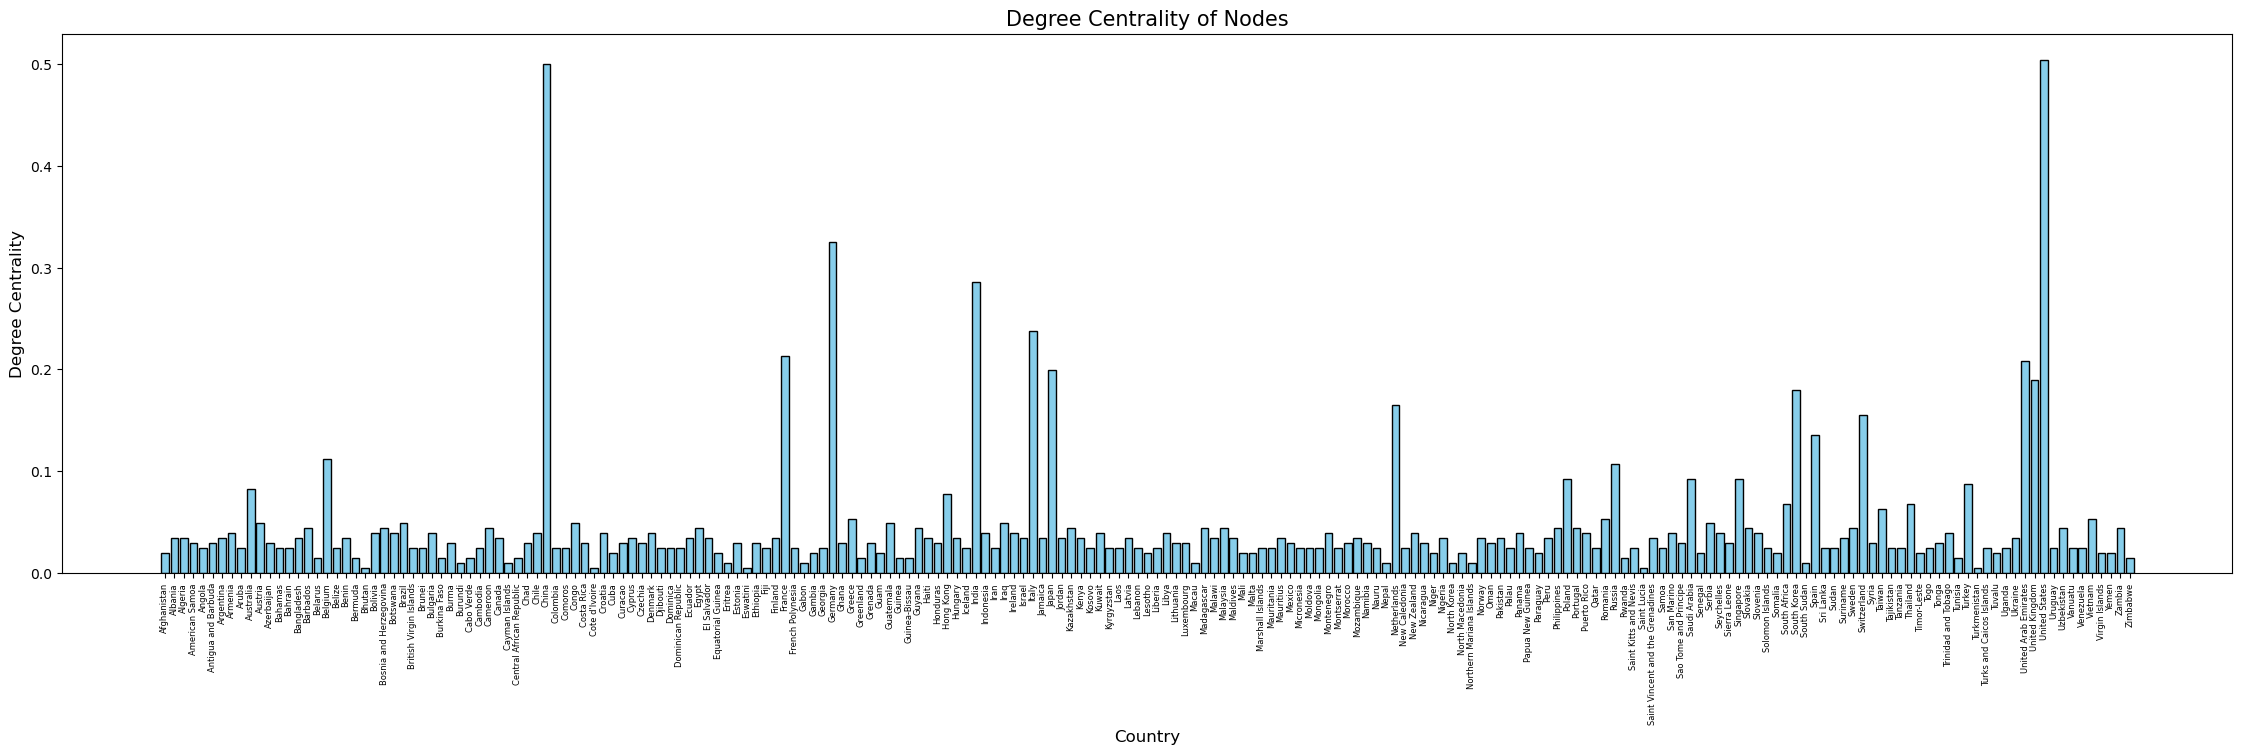

Nodes (Countries) with High Degree Centrality (> 0.15):
United States: 0.5049
China: 0.5000
Germany: 0.3252
India: 0.2864
Italy: 0.2379
France: 0.2136
United Arab Emirates: 0.2087
Japan: 0.1990
United Kingdom: 0.1893
South Korea: 0.1796
Netherlands: 0.1650
Switzerland: 0.1553


In [171]:
degree_centrality_export = nx.degree_centrality(G_export)
degree_centrality_import = nx.degree_centrality(G_import)

degree_centrality_values_export = list(degree_centrality_export.values())
degree_centrality_values_import = list(degree_centrality_import.values())

print("-----Exports Network-----")
high_degree_nodes_export = centrality(degree_centrality_export, type='Degree Centrality',threshold=0.15)

China and the United States are the most central nodes, indicating they have the highest number of direct trade connections.
European countries like Germany, Italy, and France also have high centrality, highlighting their significant role in the global export network.
Smaller countries or those with specific economic profiles (e.g., Bhutan: 0.0049, Eswatini: 0.0049) have very low centrality, reflecting limited trade connections.

-----Imports Network-----


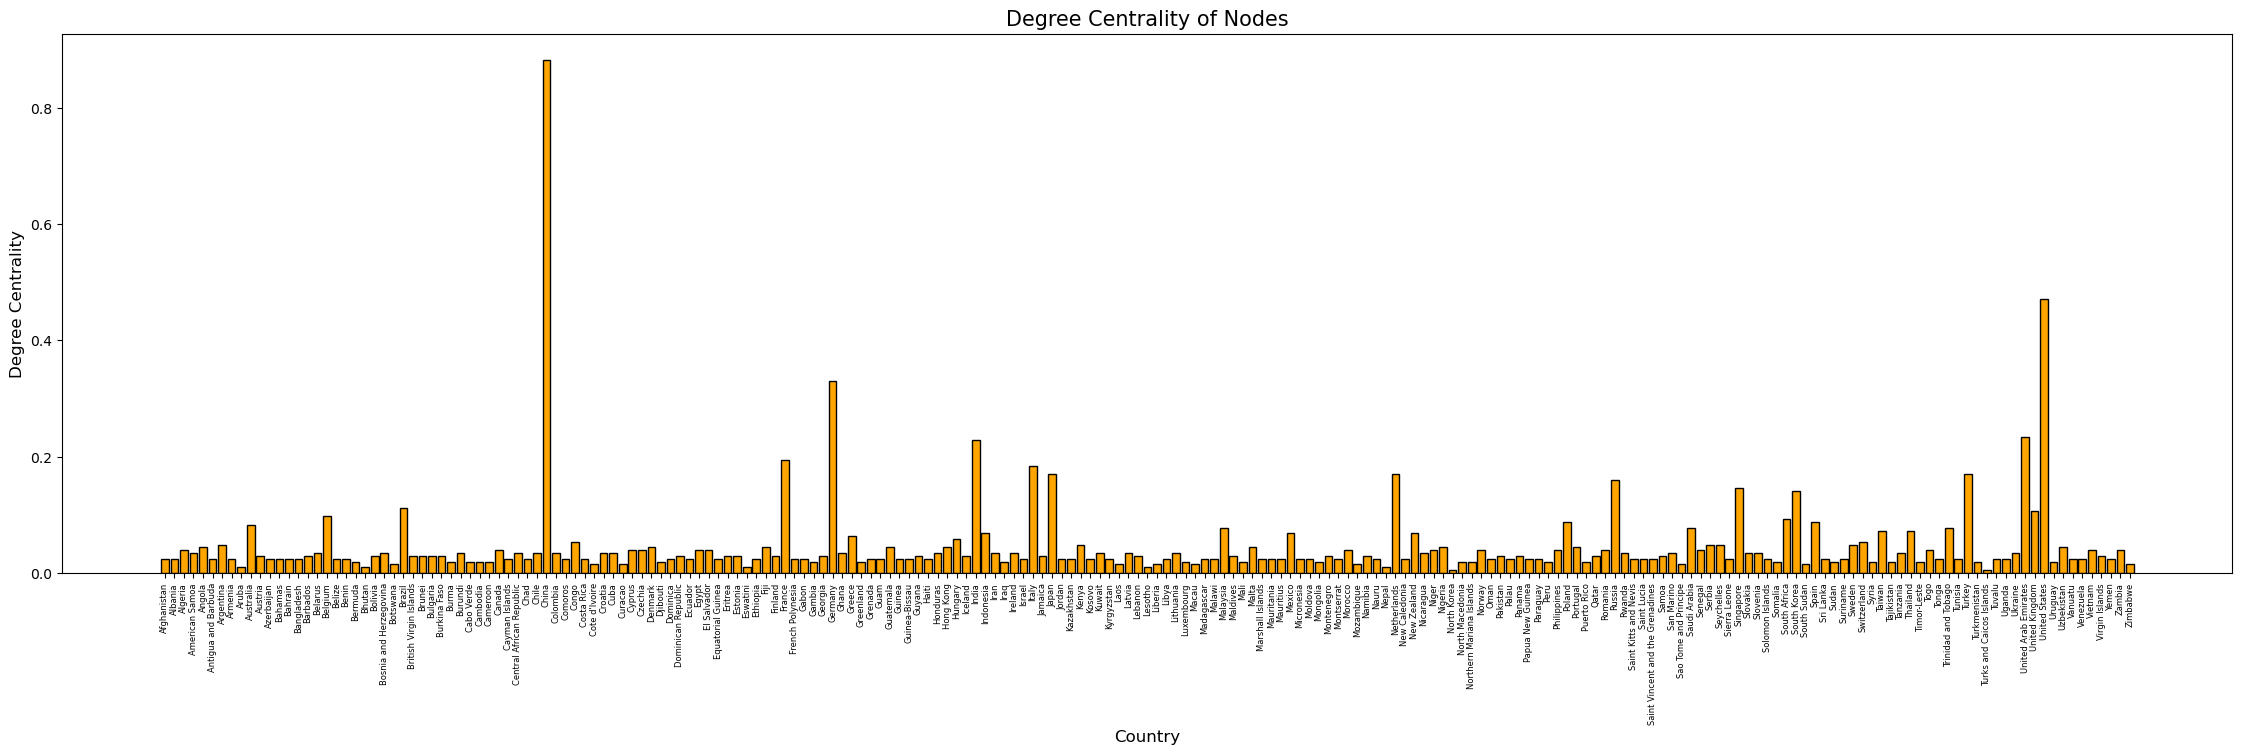

Nodes (Countries) with High Degree Centrality (> 0.15):
China: 0.8835
United States: 0.4709
Germany: 0.3301
United Arab Emirates: 0.2330
India: 0.2282
France: 0.1942
Italy: 0.1845
Turkey: 0.1699
Netherlands: 0.1699
Japan: 0.1699
Russia: 0.1602


In [169]:
print("-----Imports Network-----")
high_degree_nodes_import = centrality(degree_centrality_import, type='Degree Centrality',threshold=0.15, color='orange')

China has an exceptionally high centrality, indicating a vast number of import connections, significantly higher than any other country.
The United States and Germany also play crucial roles in the imports network, though their centrality is less than that of China.
Smaller nations and island states generally have lower centrality values (e.g., North Korea: 0.0049, Lesotho: 0.0097), reflecting fewer trade links.

#### Comparative Analysis
Global Trade Hubs:
Both China and the United States emerge as major hubs in global trade, dominating both export and import networks.
European countries like Germany, Italy, and France are pivotal in exports, while Germany and the United Kingdom are also significant in imports.

Regional Influence:
The United Arab Emirates has a relatively high centrality in imports, highlighting its role as a major trading hub in the Middle East.
Asian countries like Japan, South Korea, and India have substantial centrality values, underscoring their active participation in global trade.

Economic Marginality:
Many smaller and less economically developed countries have low centrality values in both networks, indicating limited trade activity.
Some countries, despite their size or economic status, still manage to maintain a notable presence in trade networks, such as Singapore in the imports network (0.1456).

### Degree Centrality Distribution

The degree centrality distribution is crucial for understanding the connectivity pattern within a trade network. Fitting this distribution to a power law can reveal whether the network has a scale-free structure, characterized by a few highly connected nodes (hubs) and many nodes with fewer connections. This is significant because it indicates the presence of dominant countries that act as major trade hubs, which can have substantial implications for network resilience, trade flow efficiency, and economic influence.

-----Exports Network-----


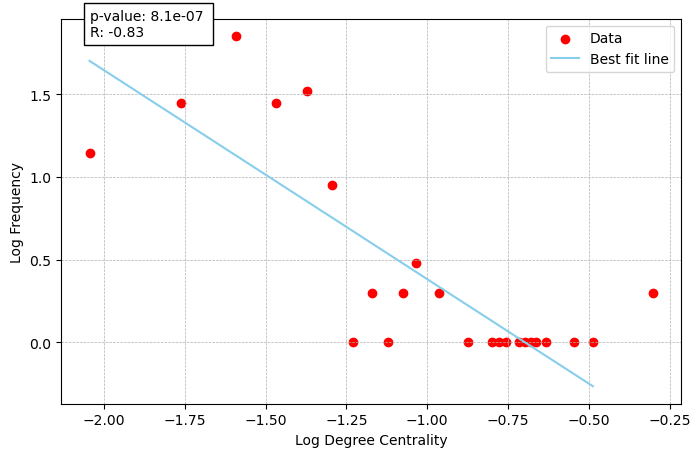

The slope of the line is: -1.2630009291737454

-----Imports Network-----


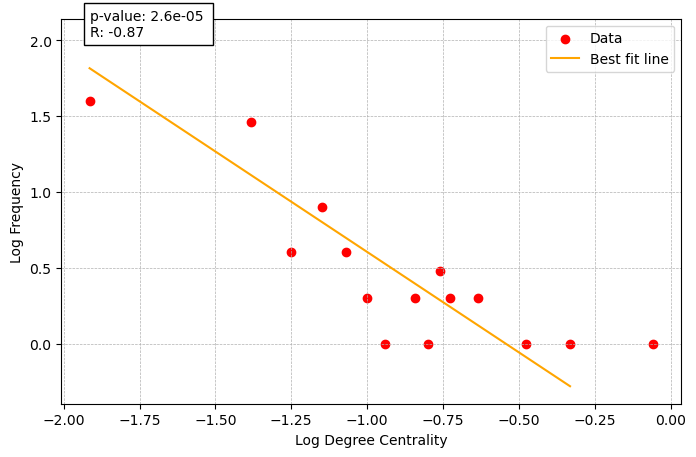

The slope of the line is: -1.322512036501067


In [28]:
print("-----Exports Network-----")
slope = plot_centrality_power_law(degree_centrality_values_export, G_export, bins=60, type='Degree', color='skyblue')
print("\n-----Imports Network-----")
slope = plot_centrality_power_law(degree_centrality_values_import, G_import, bins=60, type='Degree', color='orange')

The negative slope values (-1.263 for exports and -1.323 for imports) indicate that as the degree centrality increases, the frequency of nodes with that centrality decreases. This is consistent with a power-law distribution, suggesting the presence of a few highly connected hubs and many nodes with fewer connections.

The very low p-values (8.1e-5 for exports and 2.6e-5 for imports) indicate that the observed relationship between the degree centrality and its frequency is statistically significant. This strengthens the evidence that the degree centrality follows a power-law distribution.

The high negative R-values (-0.83 for exports and -0.87 for imports) suggest a strong negative correlation between the log-transformed degree centrality and its frequency. This confirms the power-law behavior of the network, indicating that the trade network is likely to be scale-free.

The degree centrality distribution analysis reveals that both the export and import networks exhibit characteristics of scale-free networks. This means that a few countries (nodes) play a crucial role as major hubs in global trade, while many countries have fewer trade connections. Understanding this structure is vital for policy-making and economic strategies, as these hubs are critical for the stability and efficiency of the global trade network. Identifying and supporting these hubs can enhance global trade resilience and efficiency, while also highlighting potential vulnerabilities if these hubs were to be disrupted.

### Cumulative Distribution for Degree Centrality

-----Exports Network-----


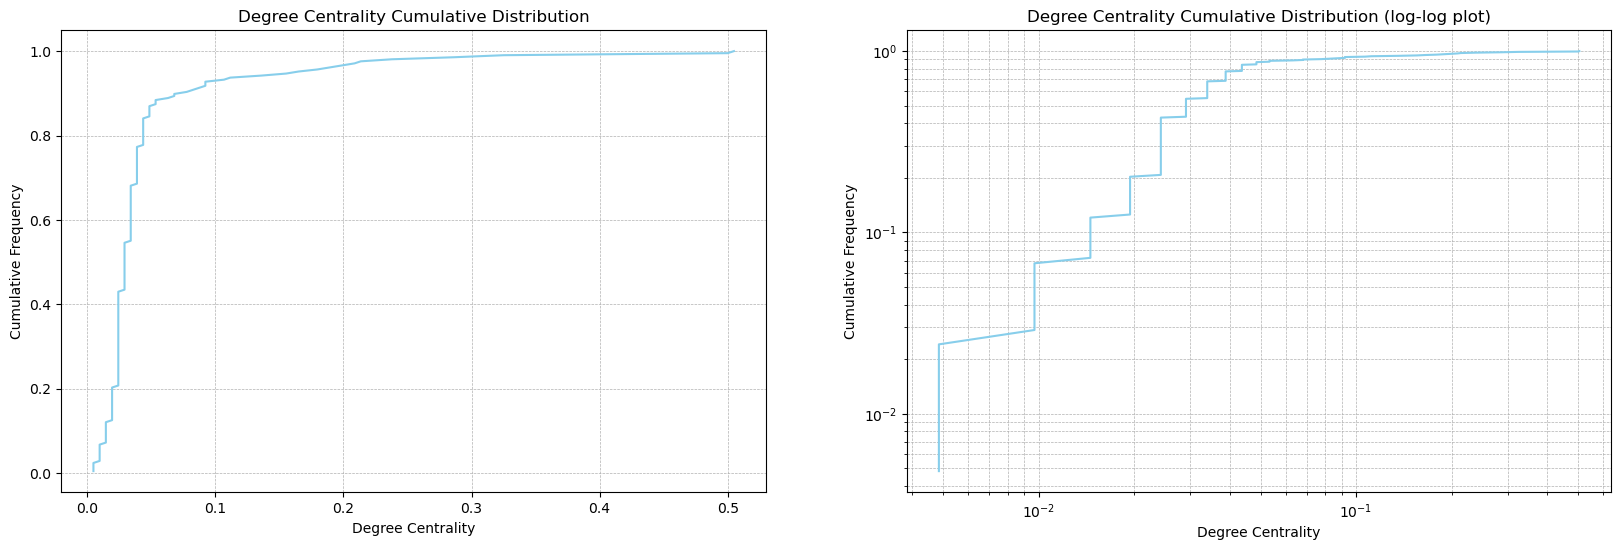

In [31]:
print("-----Exports Network-----")
cumulative_distribution(degree_centrality_values_export,type='Degree', color='skyblue', save=False)


-----Imports Network-----


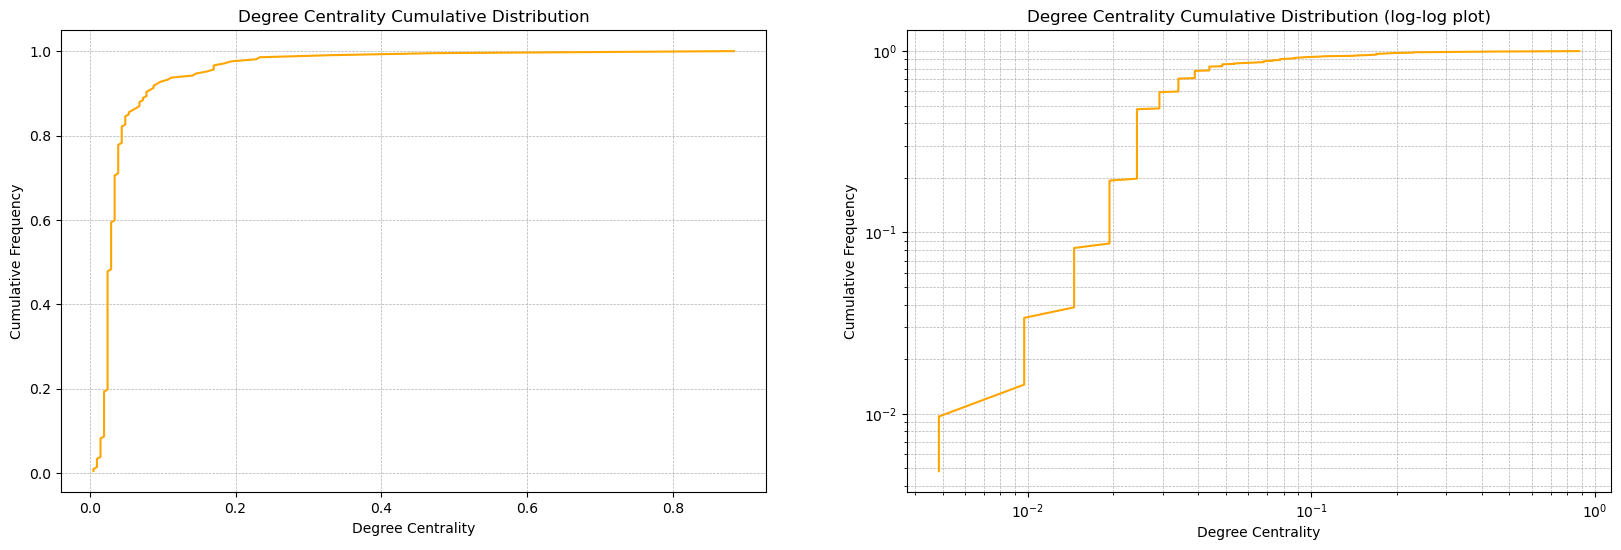

In [32]:
print("\n-----Imports Network-----")
cumulative_distribution(degree_centrality_values_import,type='Degree', color='orange', save=False)

In both the exports and the imports networks, the majority of countries have low degree centrality values, so most countries have a small number of direct trade connections, while a small number of countries have higher degree centrality values. The curves quickly rises at the beginning and then levels off, indicating that a few countries are highly connected while the rest have fewer connections.

Observing the log-log plots we can have more details about the distribution's tail: it shows a more linear trend in the middle range, suggesting a potential power-law distribution, as previously highlighted.

The steep rise in the CDF at low degree centrality values, followed by a gradual increase, suggests heterogeneous network structures where a few countries are significantly more connected than others. The presence of highly connected countries (high degree centrality) implies that these countries act as major hubs in both the network. These hubs are crucial for the stability and efficiency of global trade.


## Eigenvector centrality

Eigenvector centrality measures a node's influence based on the number and quality of its connections. In a trade network, it identifies countries that are not only well-connected but are connected to other highly influential countries. A higher eigenvector centrality suggests that a country is an important player in the global trade network, exerting significant economic influence.

-----Exports Network-----


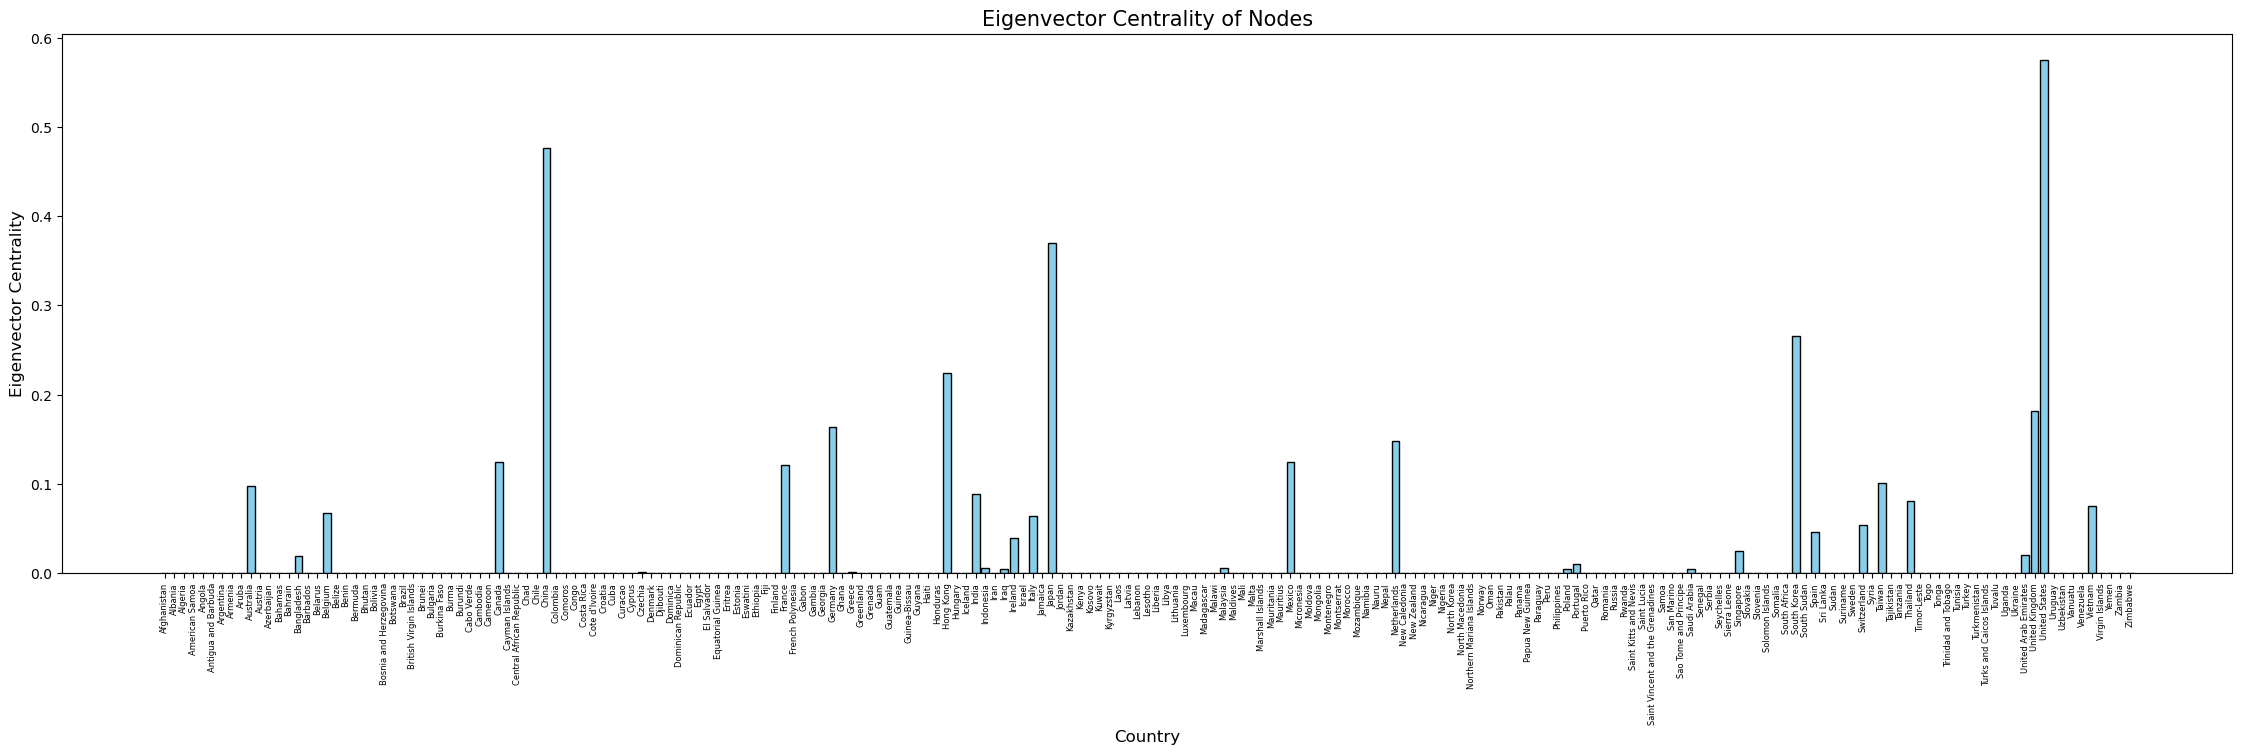

Nodes (Countries) with High Eigenvector Centrality (> 0.15):
United States: 0.5758
China: 0.4764
Japan: 0.3699
South Korea: 0.2661
Hong Kong: 0.2246
United Kingdom: 0.1818
Germany: 0.1636


In [167]:
eigenvector_centrality_export = nx.eigenvector_centrality(G_export)
eigenvector_centrality_import = nx.eigenvector_centrality(G_import)

eigenvector_centrality_values_export = list(eigenvector_centrality_export.values())
eigenvector_centrality_values_import = list(eigenvector_centrality_import.values())

print("-----Exports Network-----")
high_eigenvector_nodes_export = centrality(eigenvector_centrality_export, type='Eigenvector Centrality',threshold=0.15, color='skyblue')

United States (0.5758) has the highest eigenvector centrality, indicating a very influential position in the exports network. The US is connected to other highly influential nodes, reinforcing its central role. The rest of the highest centrality countries belongs to the eastern side of the world: China (0.4764), followed by Japan (0.3699), South Korea (0.2661) and Hong Kong (0.2246).

-----Imports Network-----


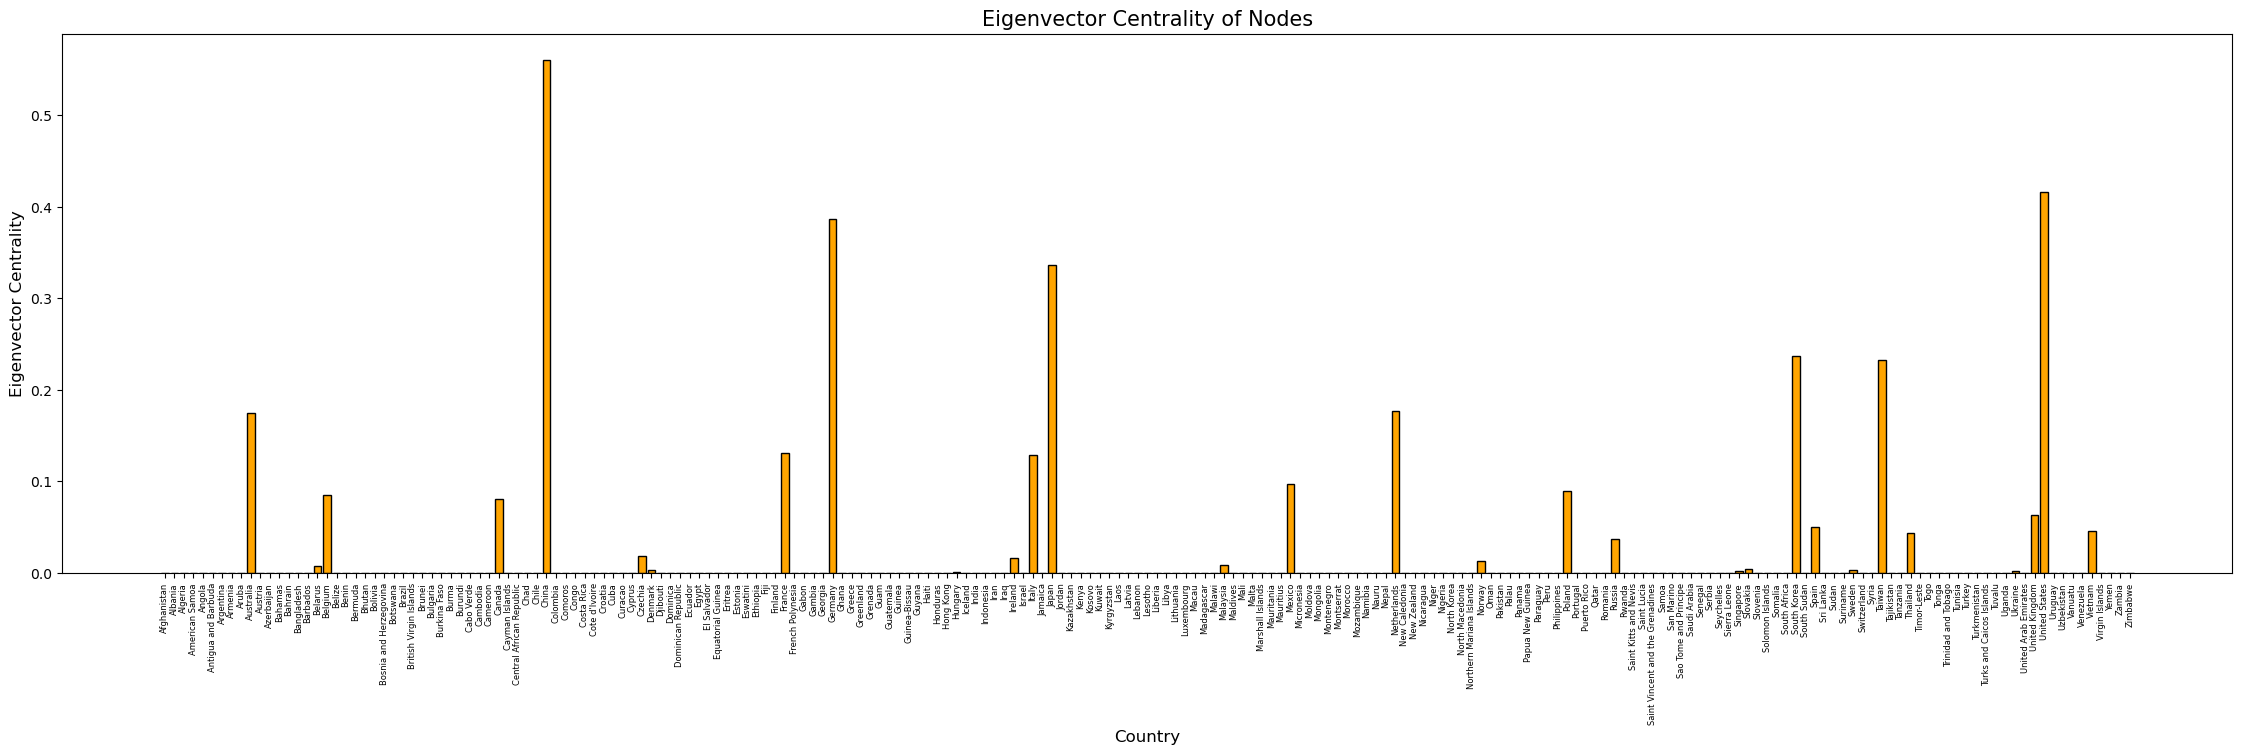

Nodes (Countries) with High Eigenvector Centrality (> 0.15):
China: 0.5607
United States: 0.4158
Germany: 0.3870
Japan: 0.3361
South Korea: 0.2368
Taiwan: 0.2325
Netherlands: 0.1773
Australia: 0.1751


In [165]:
print("-----Imports Network-----")
high_eigenvector_nodes_import = centrality(eigenvector_centrality_import, type='Eigenvector Centrality',threshold=0.15, color='orange')

By looking at the Eigenvector Centrality values of the Imports Network, we can immediately see that China (0.5607) and the United States (0.4158) swiched positions at the top, while still being the most two influential nodes. We notice a higher eigenvector centrality value in Germany (0.3870 in the imports network compared to 0.1636 in exports), demonstrating its higher influence.

#### Comparative Analysis
China and the United States are dominant in both exports and imports networks, reflecting their significant roles in global trade. Germany, Japan, and South Korea also feature prominently in both networks, indicating their importance.

Some countries have different roles in exports and imports. For example, Mexico and Canada are more influential in exports compared to imports. France and Italy have moderate influence in both networks but are more central in exports. European countries like Germany, the United Kingdom, and the Netherlands are fairly influential in both networks, highlighting Europe's critical role in global trade.

A significant number of countries have zero eigenvector centrality in both networks, indicating their limited role in global trade connections. These countries may have smaller economies, less diversified trade, or be more regionally focused.


### Eigenvector centrality distribution

-----Exports Network-----


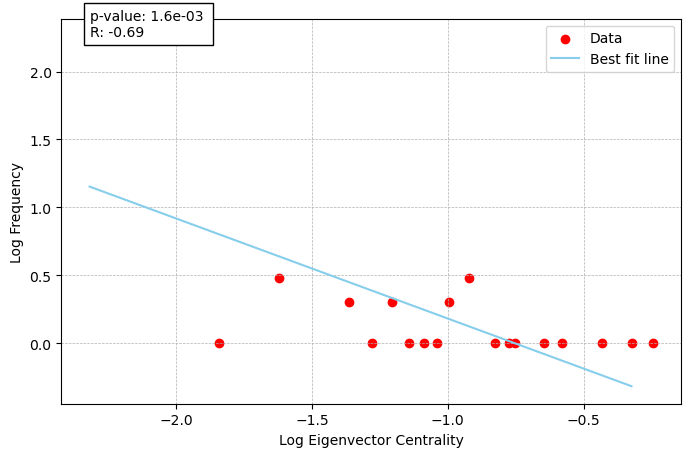

The slope of the line is: -0.7364451312092158

-----Imports Network-----


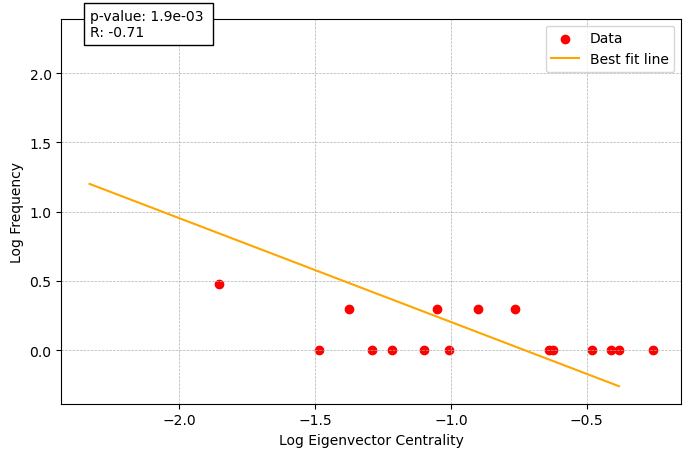

The slope of the line is: -0.749266711996696


In [41]:
print("-----Exports Network-----")
slope_e_export = plot_centrality_power_law(eigenvector_centrality_values_export, G_export, bins=60, type='Eigenvector', color='skyblue')
print("\n-----Imports Network-----")
slope_e_import = plot_centrality_power_law(eigenvector_centrality_values_import, G_import, bins=60, type='Eigenvector', color='orange')

The slopes for both networks are negative, indicating a decreasing trend. In a power-law distribution, this suggests that high eigenvector centrality values are less frequent, while lower values are more common.
The slopes are quite similar (-0.7364 for exports and -0.7493 for imports), indicating a similar rate of decay in the centrality distributions across both networks.

Both p-values (1.6e-03 for exports and 1.9e-03 for imports) are very low, indicating that the slope is statistically significant. This means the fit of the power-law model to the centrality data is robust.

The R-values (-0.69 for exports and -0.71 for imports) are negative and close to -0.7, indicating a moderate to strong negative correlation. This suggests that as the eigenvector centrality increases, the frequency of such nodes decreases, which is expected in networks where a few nodes have high centrality and many nodes have low centrality.

The analysis of the eigenvector centrality distributions for both the exports and imports networks demonstrates a typical power-law behavior. A few countries (nodes) dominate in terms of centrality, having significant influence and connections, while the majority have lower centrality values. This distribution is consistent with many real-world networks where influence or connectivity is not evenly distributed.

### Cumulative Distribution for Eigenvector Centrality

-----Exports Network-----


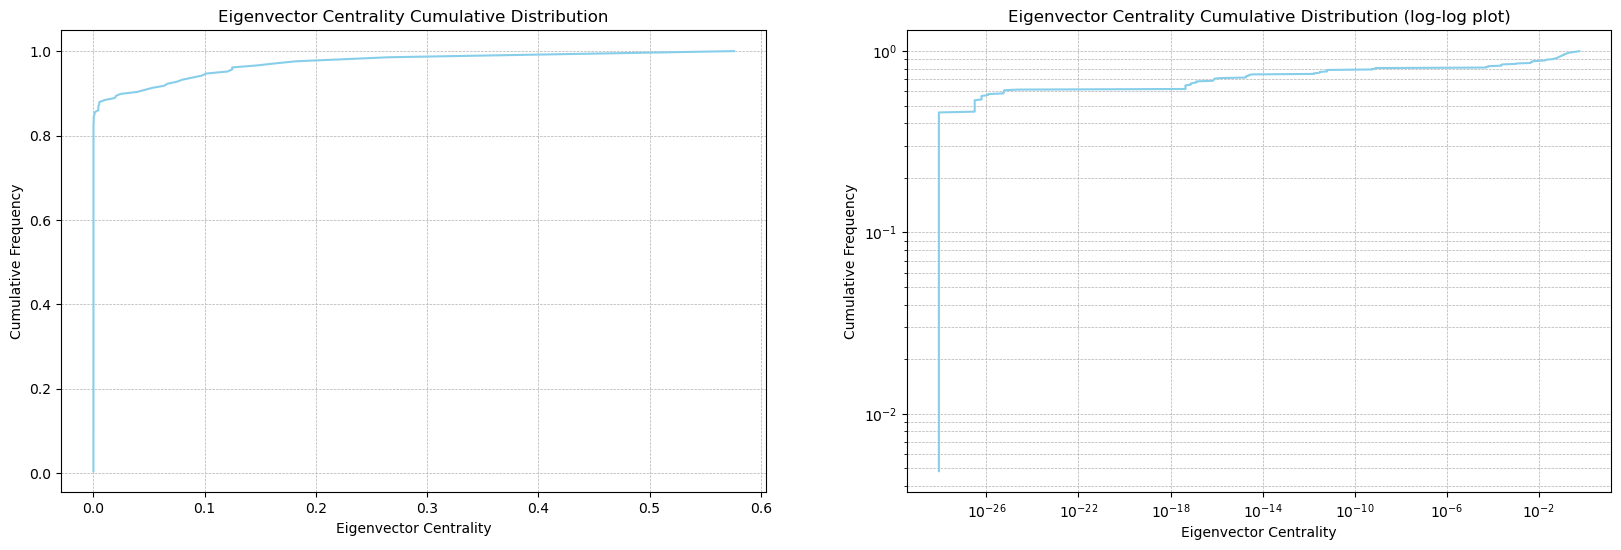


-----Imports Network-----


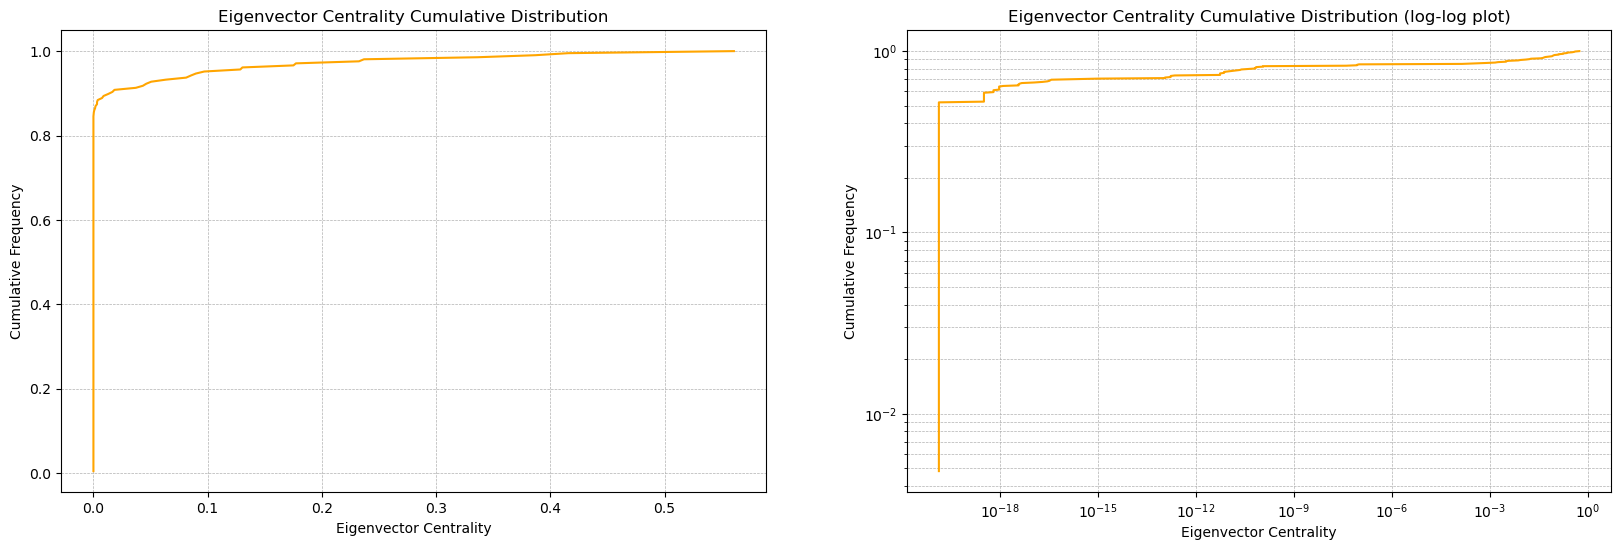

In [44]:
print("-----Exports Network-----")
cumulative_distribution(eigenvector_centrality_values_export,type='Eigenvector', color='skyblue', save=False)
print("\n-----Imports Network-----")
cumulative_distribution(eigenvector_centrality_values_import,type='Eigenvector', color='orange', save=False)

By looking at both the linear scale plots, the CDF increases sharply at very low values of eigenvector centrality.
This indicates that most nodes (countries) have low eigenvector centrality, suggesting they are not highly influential within the networks. These countries might depend on the central nodes for their connections and are less influential in shaping the overall network. 

The log-log plots show a long tail, indicating the presence of a few countries with significantly higher eigenvector centrality.
This suggests that small number of countries are highly central and influential within both networks.

The networks likely exhibits a hierarchical structure, typical of many natural and social networks, where a small number of nodes play a crucial role in maintaining the network's integrity.

## Betweenness centrality

Betweenness centrality measures the extent to which a node lies on the shortest paths between other nodes. In trade networks, it indicates the countries that act as intermediaries in trade routes, controlling the flow of goods between other nations. A country with high betweenness centrality has significant influence over trade flow and can impact the efficiency of global trade routes.

-----Exports Network-----


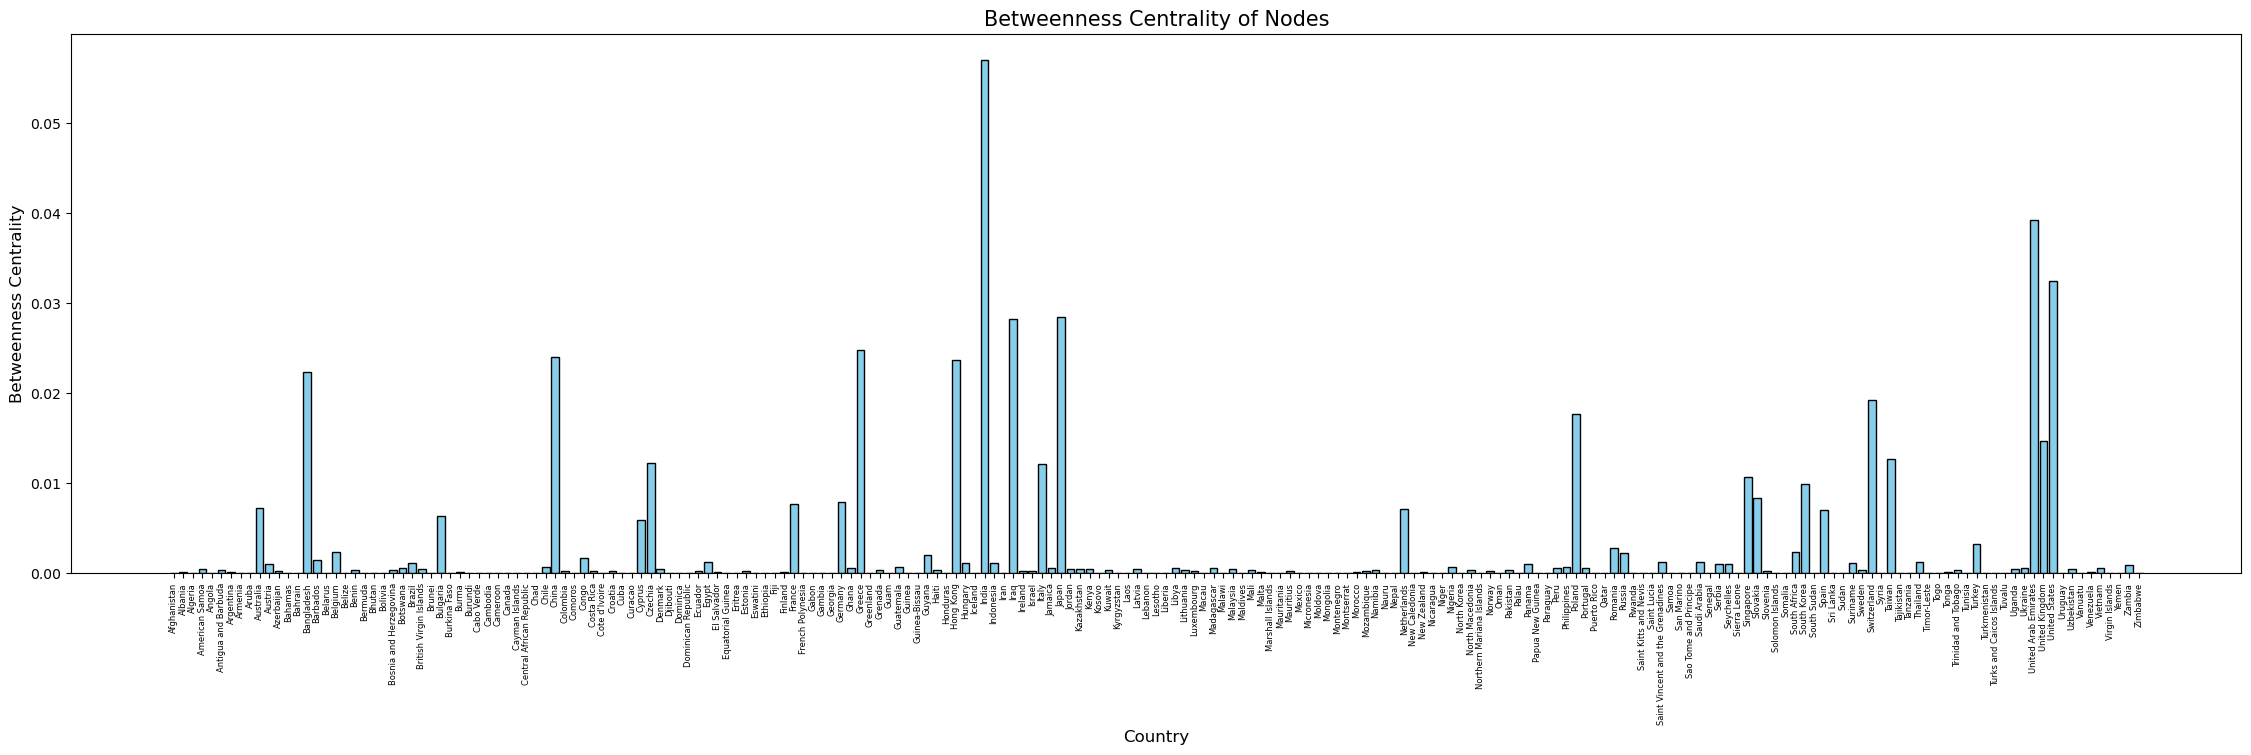

Nodes (Countries) with High Betweenness Centrality (> 0.015):
India: 0.0571
United Arab Emirates: 0.0393
United States: 0.0325
Japan: 0.0284
Iraq: 0.0282
Greece: 0.0248
China: 0.0240
Hong Kong: 0.0236
Bangladesh: 0.0224
Switzerland: 0.0192
Poland: 0.0176


In [163]:
betweenness_centrality_export = nx.betweenness_centrality(G_export)
betweenness_centrality_import = nx.betweenness_centrality(G_import)

betweenness_centrality_values_export = list(betweenness_centrality_export.values())
betweenness_centrality_values_import = list(betweenness_centrality_import.values())

print("-----Exports Network-----")
high_betweenness_nodes_export = centrality(betweenness_centrality_export, type='Betweenness Centrality',threshold=0.015, color='skyblue')


India (0.0571) has the highest betweenness centrality in the export network, indicating a key role in facilitating trade connections between other countries. United States (0.0325) and United Arab Emirates (0.0393) are crucial nodes in the network, acting as major hubs for trade routes, as it can be said for Japan (0.0284) and Iraq (0.0282), suggesting their significant intermediary roles.
are critical for maintaining the flow of goods and can influence the stability and efficiency of the network.

Many countries, such as Albania (0.0001), Antigua and Barbuda (0.0004), and Botswana (0.0005), have very low betweenness centrality values, indicating they are peripheral nodes in the network with minimal intermediary trade connections.

-----Imports Network-----


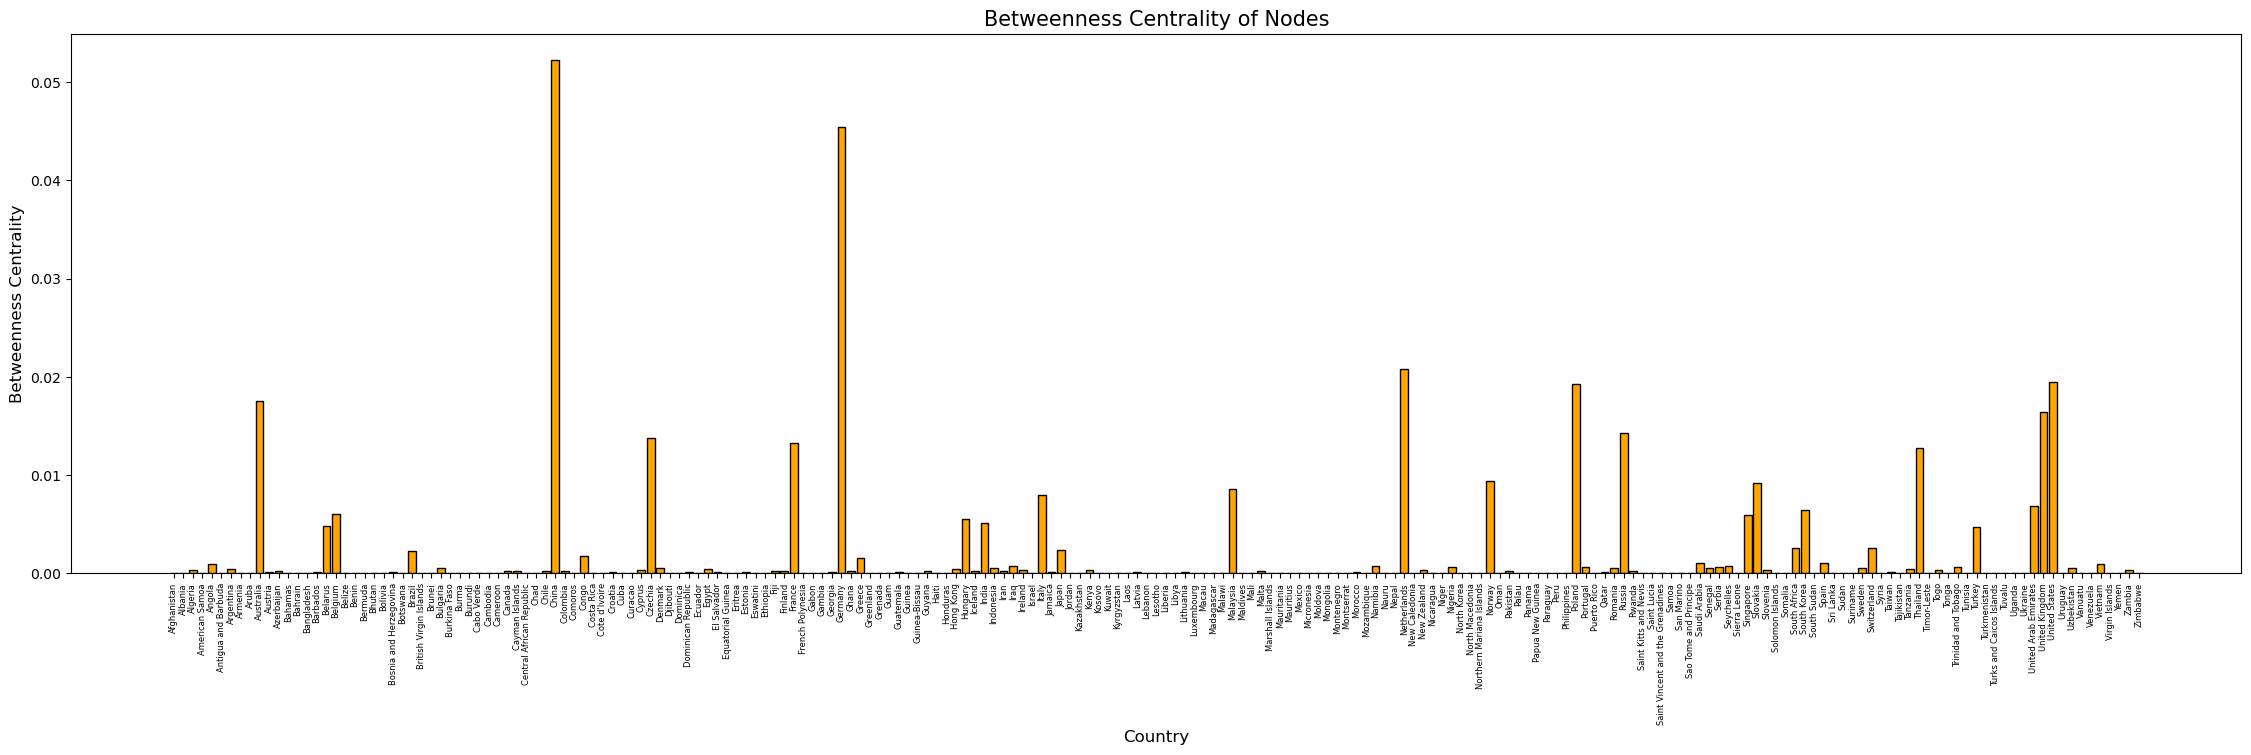

Nodes (Countries) with High Betweenness Centrality (> 0.01):
China: 0.0523
Germany: 0.0455
Netherlands: 0.0208
United States: 0.0195
Poland: 0.0192
Australia: 0.0175
United Kingdom: 0.0164
Russia: 0.0143
Czechia: 0.0137
France: 0.0132
Thailand: 0.0128


In [161]:
print("-----Imports Network-----")
high_betweenness_nodes_export = centrality(betweenness_centrality_import, type='Betweenness Centrality',threshold=0.01, color='orange')

China (0.0523) and Germany (0.0455) have the highest betweenness centrality in the import network, followed by a group of 4 countries: United States (0.0195), Poland (0.0192), Netherlands (0.0208), and United Kingdom (0.0164) which are also key intermediaries.

Many countries, such as Samoa (0.0000), Panama (0.0000), and Ukraine (0.0000), have zero betweenness centrality, indicating they are on the periphery of the import network.

#### Comparative Analysis
Both networks highlight specific countries as major hubs, such as the United States, China, and Germany, reflecting their significant roles in global trade.

Many smaller or less economically powerful countries appear as peripheral nodes in both networks, indicating limited influence on global trade flows.

Some countries exhibit different centrality levels between export and import networks. For example, India is highly central in the export network but not as much in the import network, while China is central in both networks but especially dominant in imports.

### Betweenness Centrality distribution

-----Exports Network-----


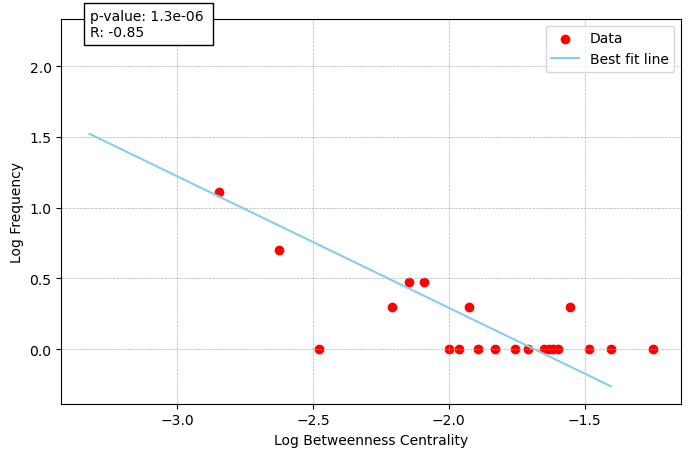

The slope of the line is: -0.9296039841746151
-----Imports Network-----


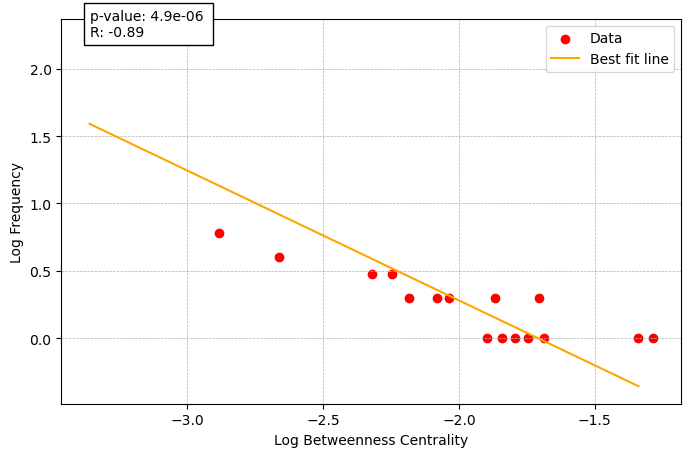

The slope of the line is: -0.9631881161012804


In [53]:
print("-----Exports Network-----")
slope_b_export = plot_centrality_power_law(betweenness_centrality_values_export, G_export, bins=60, type='Betweenness', color='skyblue')
print("-----Imports Network-----")
slope_b_import = plot_centrality_power_law(betweenness_centrality_values_import, G_import, bins=60, type='Betweenness', color='orange')

The negative slopes in the log-log plot suggest that betweenness centrality in both export and import networks follows a power-law distribution. This implies that a small number of countries have very high betweenness centrality, acting as major hubs or bridges in the network, while the majority of countries have low betweenness centrality.

The high absolute values of the R-values (-0.85 for exports and -0.89 for imports) indicate a strong linear relationship on the log-log scale, further confirming the power-law nature of the distribution.

The very low p-values (1.3e-06 for exports and 4.9e-06 for imports) suggest that the results are statistically significant. This means that the observed power-law distribution is not due to random chance and reflects a fundamental characteristic of the trade networks.

The reliance on a few key countries for maintaining the flow of goods highlights potential vulnerabilities. Disruptions in these central hubs can have a widespread impact on the entire network, emphasizing the need for robust trade policies and diversification of trade routes.

### Cumulative Distribution for Betweenness Centrality

-----Exports Network-----


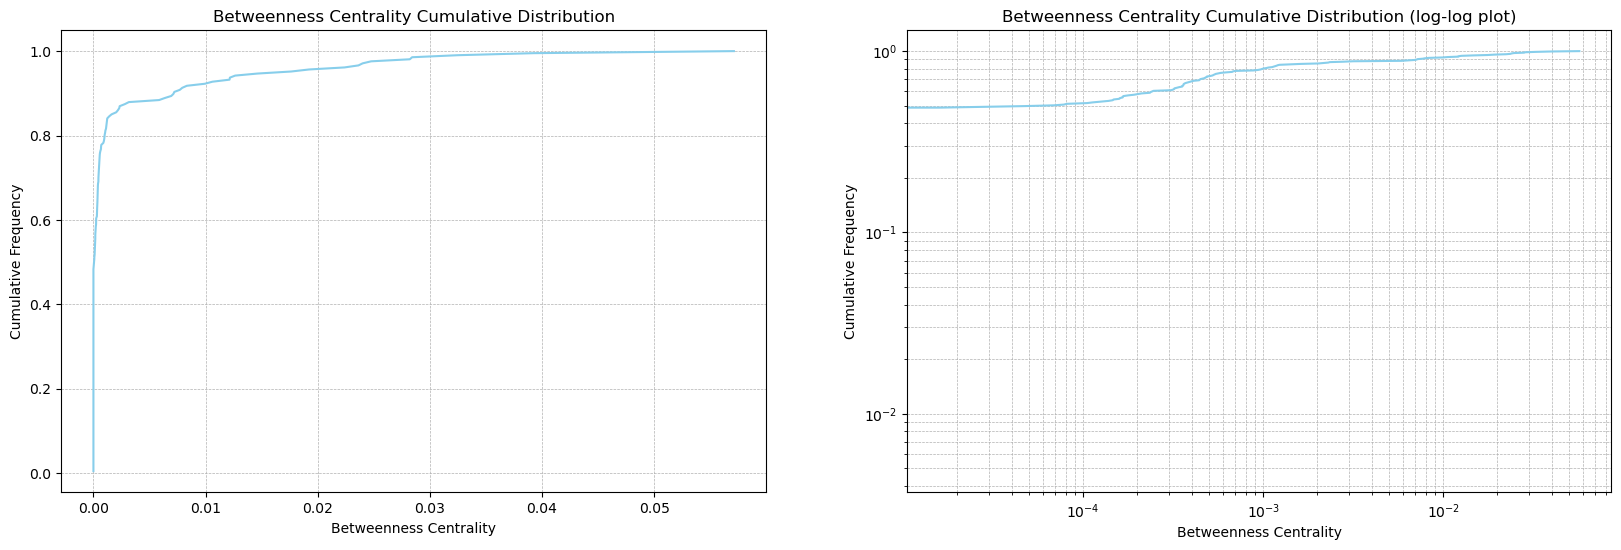


-----Imports Network-----


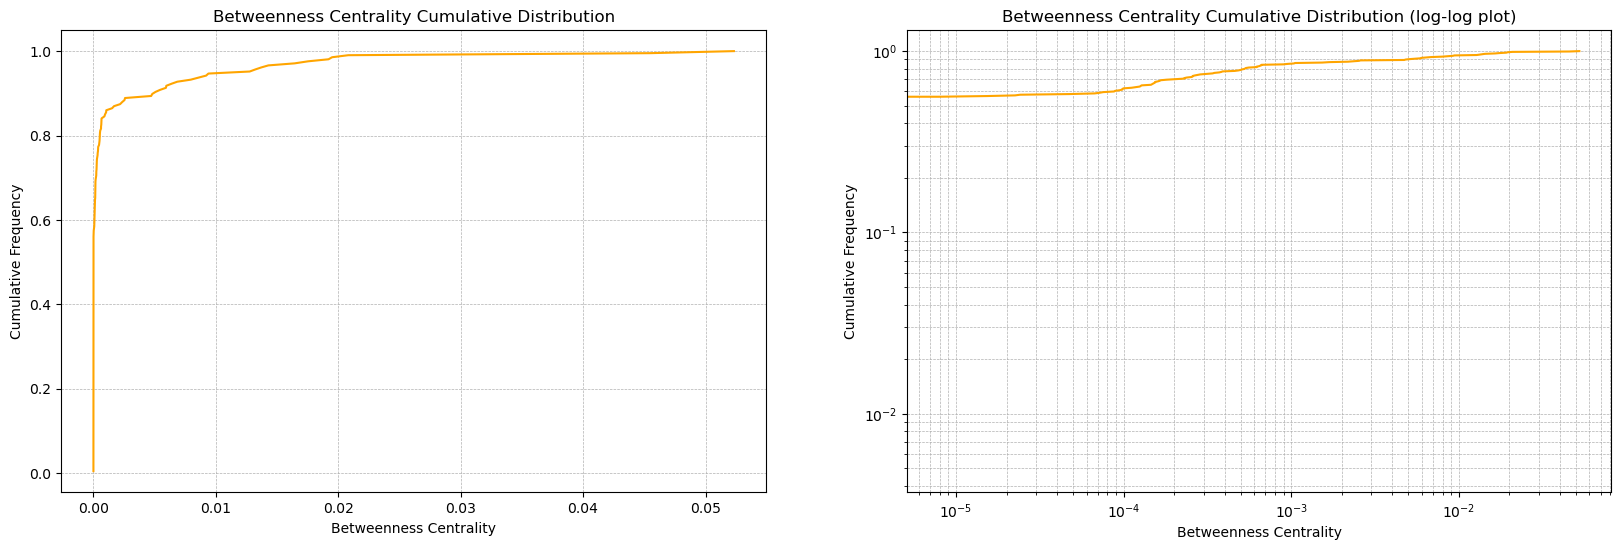

In [56]:
print("-----Exports Network-----")
cumulative_distribution(betweenness_centrality_values_export,type='Betweenness', color='skyblue', save=False)
print("\n-----Imports Network-----")
cumulative_distribution(betweenness_centrality_values_import,type='Betweenness', color='orange', save=False)

The networks are again dominated by a few central countries with high betweenness centrality, which are crucial for maintaining the network's connectivity and facilitating trade flows. Most countries are on the periphery with low betweenness centrality, indicating they play minor roles in connecting other countries.

The sharp increase in the cumulative frequency at low centrality values followed by a long tail confirm the typical power-law distribution.

## Closeness centrality

Closeness centrality measures how quickly a node can reach all other nodes in the network. In a trade network, it indicates how efficiently a country can access other countries' markets. A higher closeness centrality suggests that a country is geographically or economically well-positioned to trade with others, reducing trade costs and improving market access.

-----Exports Network-----


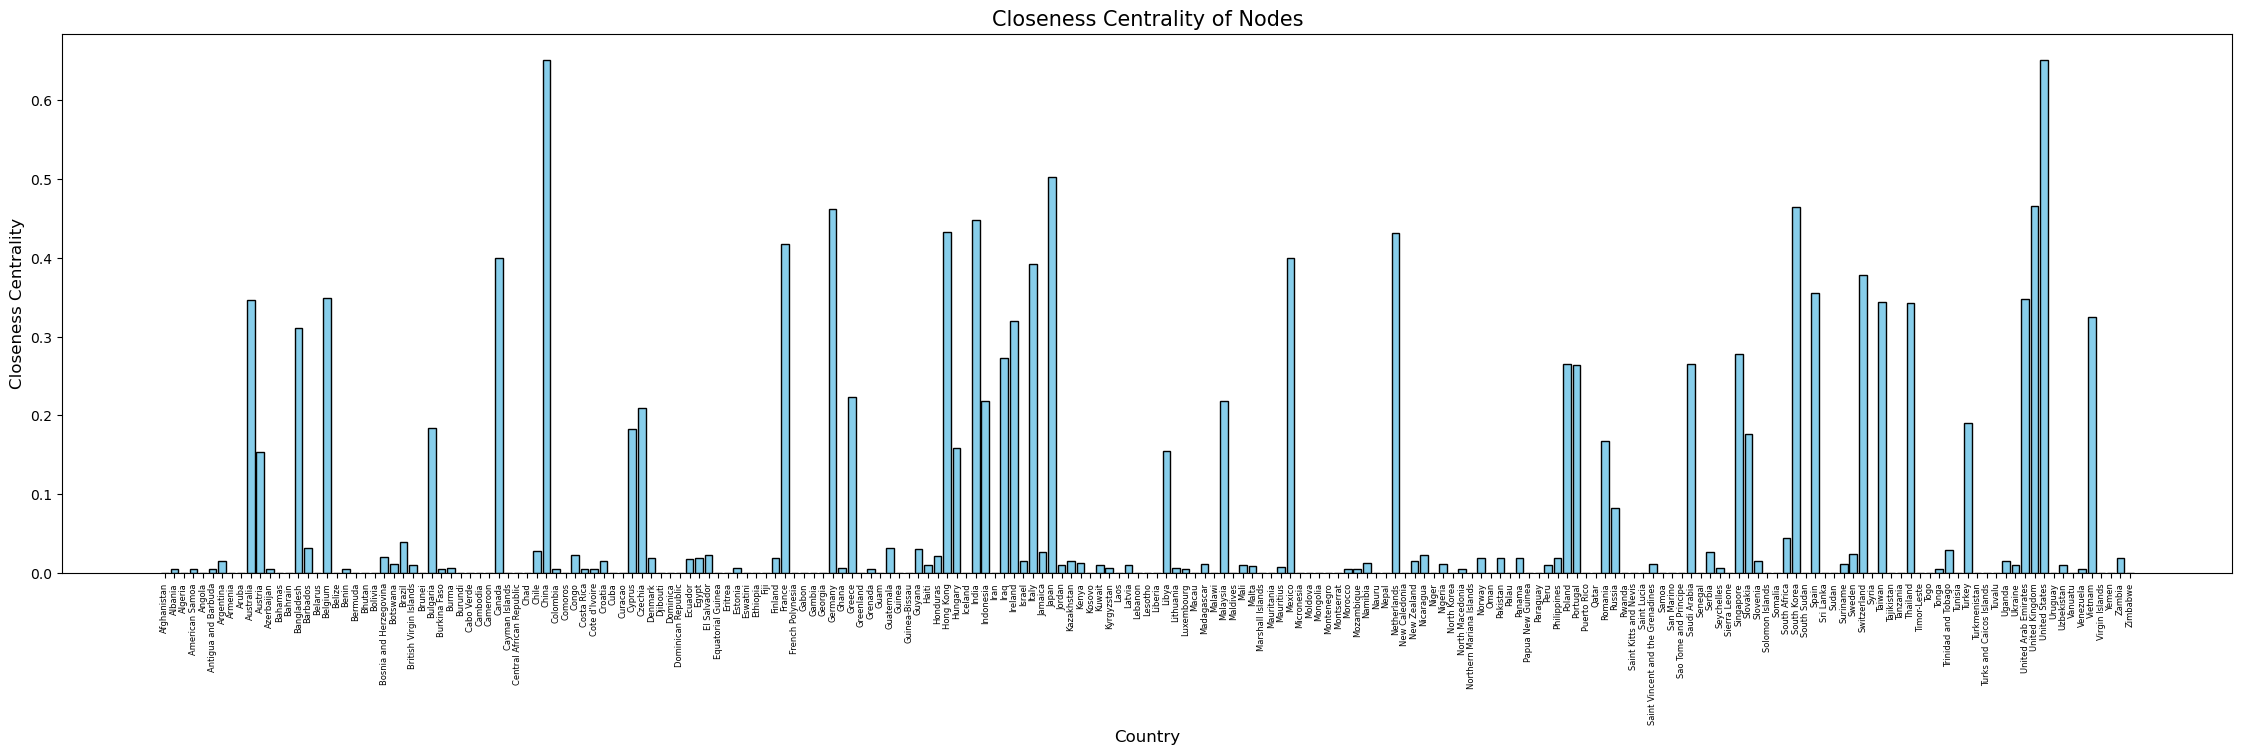

Nodes (Countries) with High Closeness Centrality (> 0.35):
China: 0.6518
United States: 0.6518
Japan: 0.5025
United Kingdom: 0.4658
South Korea: 0.4647
Germany: 0.4626
India: 0.4474
Hong Kong: 0.4322
Netherlands: 0.4313
France: 0.4180
Canada: 0.4000
Mexico: 0.3992
Italy: 0.3923
Switzerland: 0.3785
Spain: 0.3548


In [151]:
closeness_centrality_export = nx.closeness_centrality(G_export)
closeness_centrality_import = nx.closeness_centrality(G_import)
closeness_centrality_values_export = list(closeness_centrality_export.values())
closeness_centrality_values_import = list(closeness_centrality_import.values())

print("-----Exports Network-----")
high_closeness_nodes_export = centrality(closeness_centrality_export, type='Closeness Centrality',threshold=0.35, color='skyblue')

China and the United States both have the highest closeness centrality in the exports network, indicating they are the most central and influential exporters. Their high centrality suggests strong trade linkages with many other countries, making them pivotal players in global exports. Japan, the United Kingdom, South Korea, and Germany follow, showing these countries are also highly connected and significant in the export network. Other European countries like the Netherlands, France, and Italy also rank high, reflecting Europe's strong role in global trade.

-----Imports Network-----


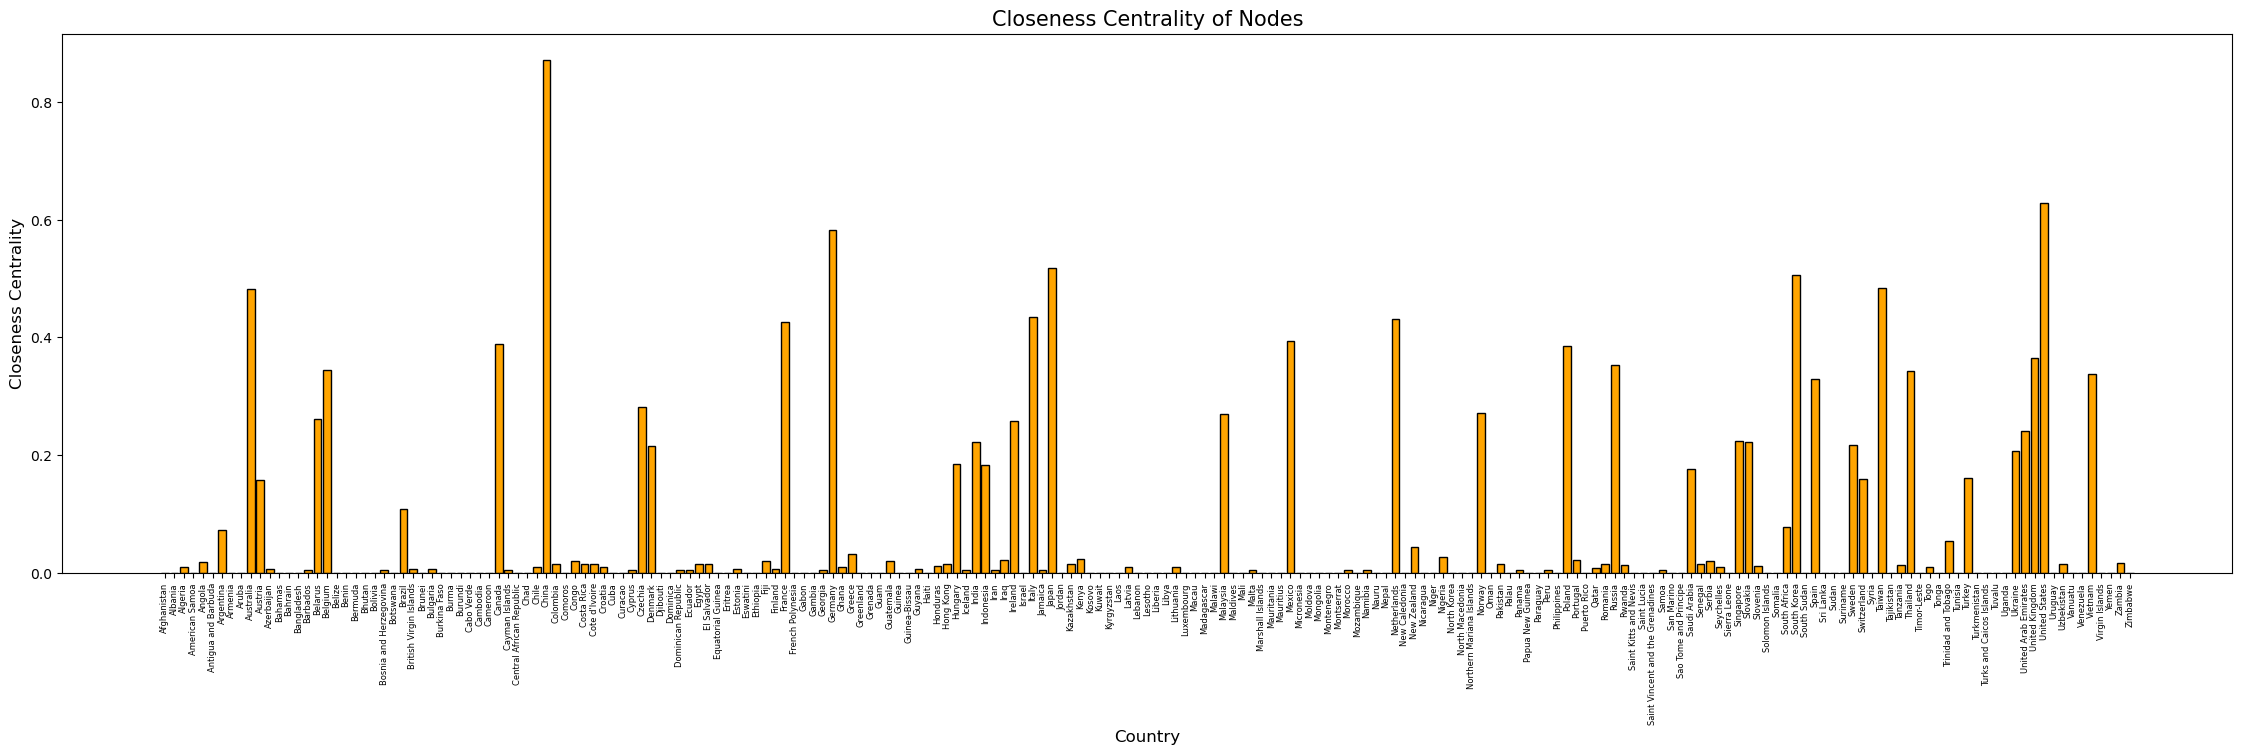

Nodes (Countries) with High Closeness Centrality (> 0.35):
China: 0.8718
United States: 0.6277
Germany: 0.5829
Japan: 0.5178
South Korea: 0.5062
Taiwan: 0.4846
Australia: 0.4823
Italy: 0.4350
Netherlands: 0.4313
France: 0.4268
Mexico: 0.3946
Canada: 0.3893
Poland: 0.3856
United Kingdom: 0.3649
Russia: 0.3529


In [156]:
print("-----Imports Network-----")
high_closeness_nodes_import = centrality(closeness_centrality_import, type='Closeness Centrality',threshold=0.35, color='orange')

China has a significantly higher closeness centrality in the imports network compared to other countries, underscoring its role as the largest importer with extensive trade relationships.
The United States and Germany also have high centrality, indicating their substantial import activity and integration into the global trade network.
Asian countries like Japan, South Korea, and Taiwan rank prominently, highlighting Asia's critical role in importing.

#### Comparative Analysis
China is at the top of both the exports and imports networks, reflecting its central position in global trade. Its high closeness centrality scores show its extensive trade connections, making it a vital hub in both the import and export domains.
The US also ranks highly in both networks, though its closeness centrality is higher in the exports network. This suggests that while the US is a significant player in both importing and exporting, its role as an exporter is slightly more pronounced in terms of connectivity.
China and the United States are central hubs in the global trade network, with extensive trade connections that make them pivotal in both importing and exporting. This centrality positions them as critical players in global economic stability and growth.

Countries like the United Kingdom, France, and the Netherlands are more prominent in the exports network, while Germany stands out in both. This indicates a strong export orientation for several European nations.

The high centrality scores of various Asian countries underline the significant shift towards Asia in global trade dynamics, driven by rapid economic growth and industrialization in the region.

### Closeness centrality distribution

-----Exports Network-----


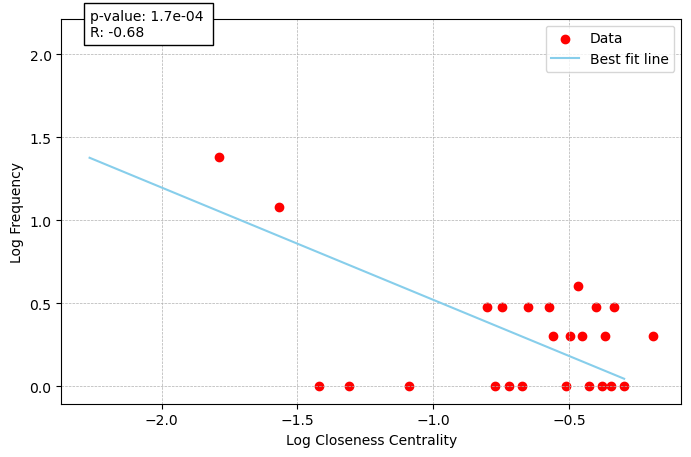

The slope of the line is: -0.6758966469357606

-----Imports Network-----


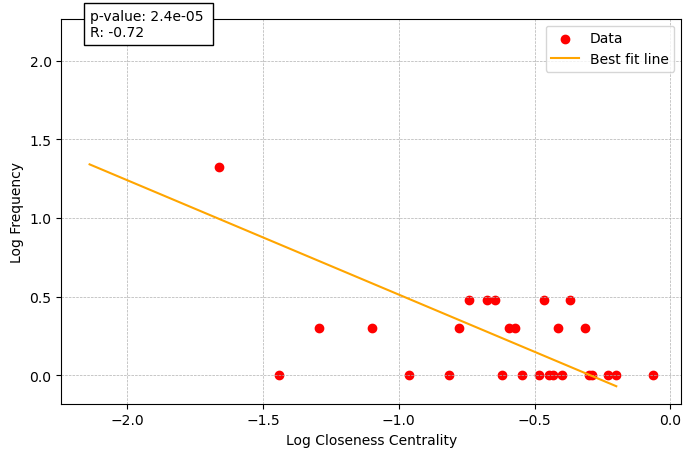

The slope of the line is: -0.7272260243601809


In [62]:
print("-----Exports Network-----")
slope_c_export = plot_centrality_power_law(closeness_centrality_values_export, G_export, bins=60, type='Closeness', color='skyblue')
print("\n-----Imports Network-----")
slope_c_import = plot_centrality_power_law(closeness_centrality_values_import, G_import, bins=60, type='Closeness', color='orange')

Both the exports and imports networks exhibit a negative slope in the logarithmic plot of centrality values versus frequency. The negative slopes indicate that while a few nodes in both networks have very high centrality values, the majority of nodes have lower centrality values. This aligns with typical network structures where a small number of nodes act as hubs or are highly central, influencing many others.


For the exports network we have a moderate negative correlation (R ≈ -0.68) suggests that as nodes in the exports network increase in closeness centrality, their frequency decreases following a power-law distribution. This could imply that certain countries in the exports network are more central in terms of trade relations.
Imports Network: Stronger negative correlation (R ≈ -0.72) indicates a more pronounced power-law distribution. This suggests that in the imports network, a few countries tend to be more central in terms of importing goods.

## Pagerank

PageRank is a measure of the importance of nodes in a network, taking into account both the quantity and quality of incoming links. In the context of trade, it indicates the overall importance of a country within the global trade network. A high PageRank score suggests that a country is a significant hub, attracting substantial trade from other countries.

-----Exports Network-----


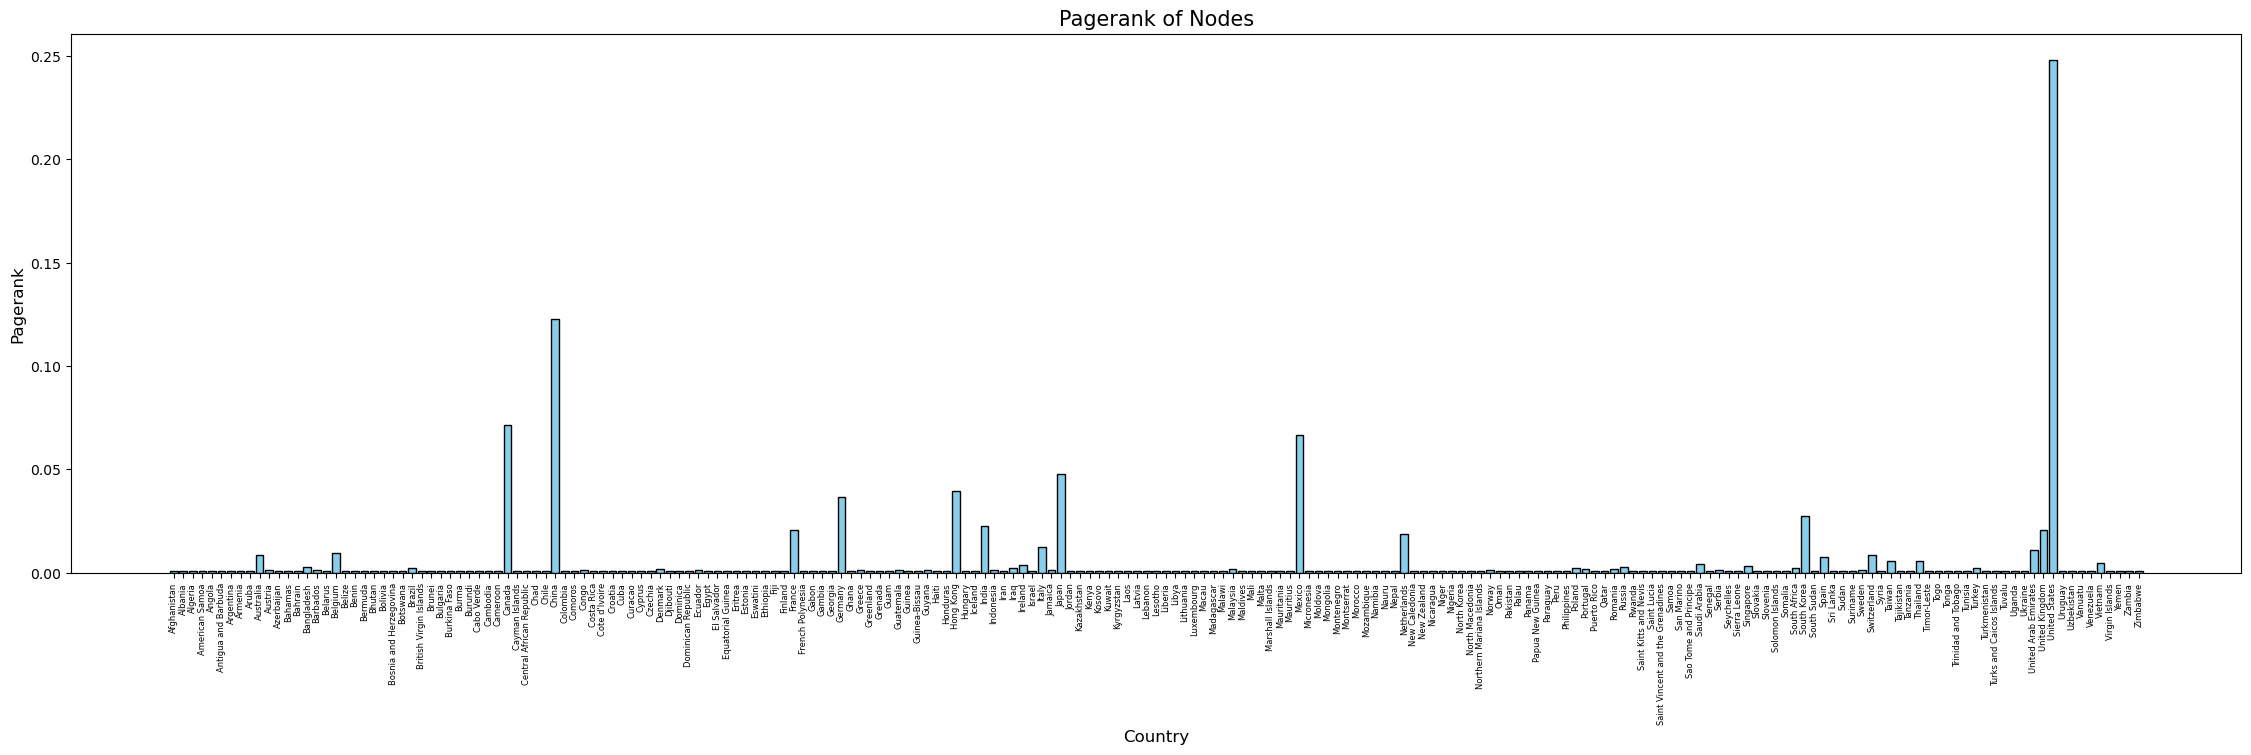

Nodes (Countries) with High Pagerank (> 0.04):
United States: 0.2484
China: 0.1229
Canada: 0.0716
Mexico: 0.0669
Japan: 0.0479

-----Imports Network-----


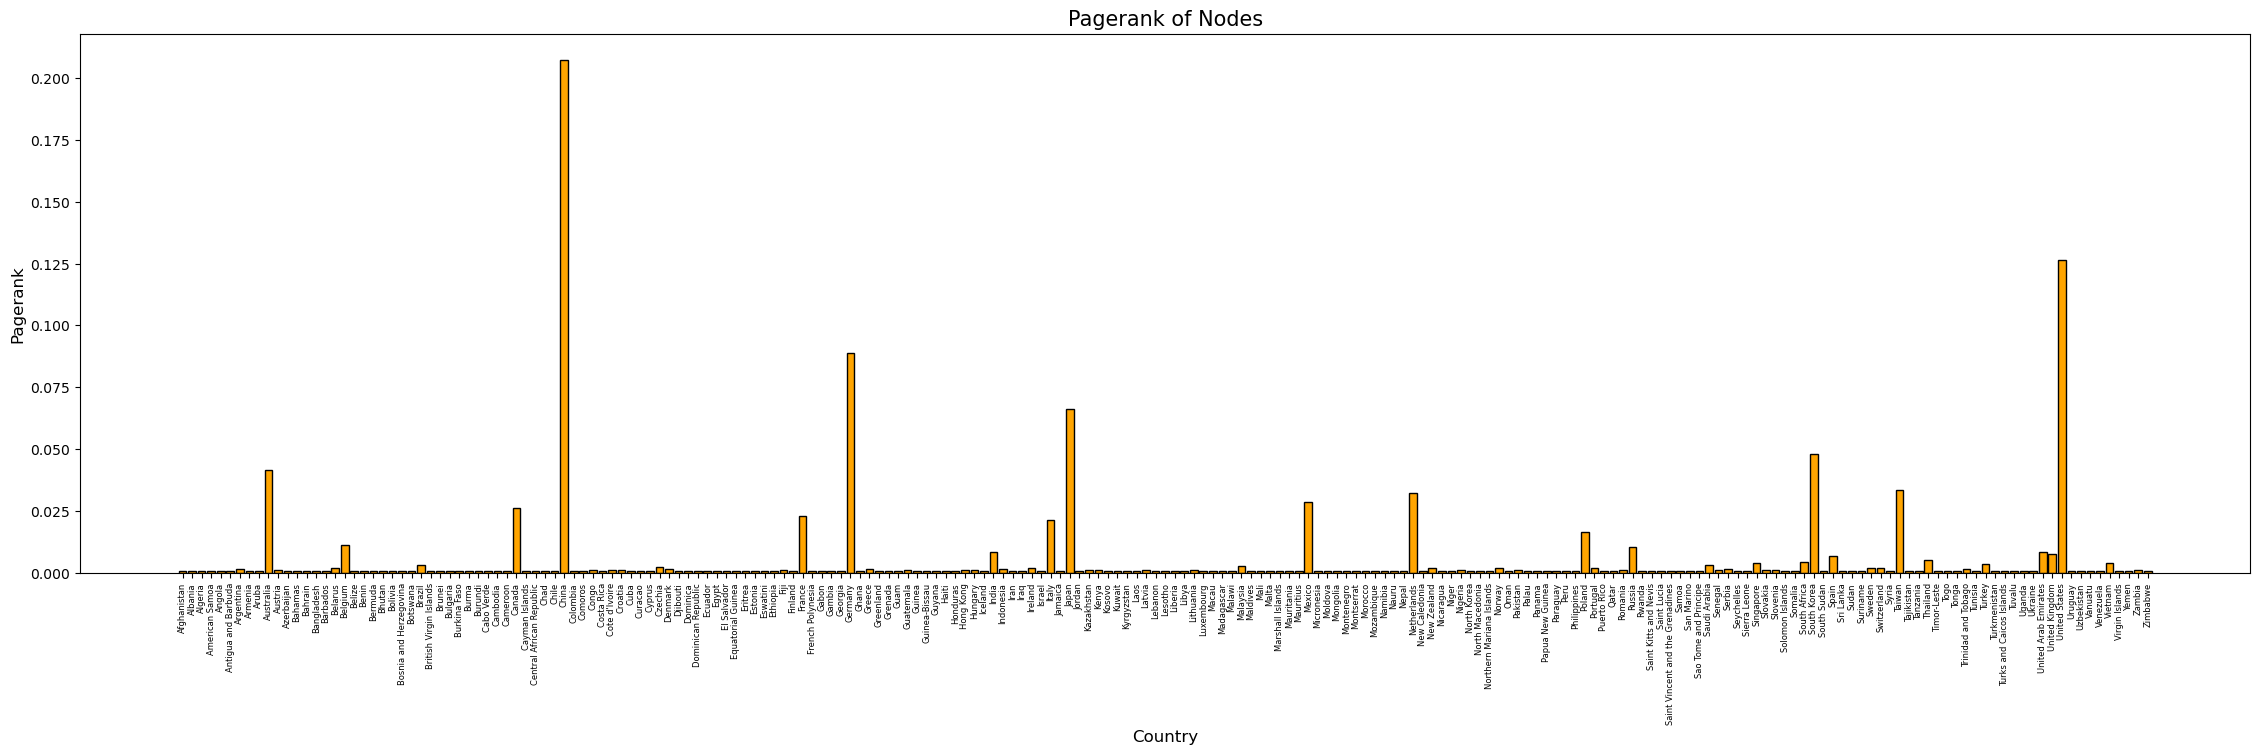

Nodes (Countries) with High Pagerank (> 0.04):
China: 0.2075
United States: 0.1264
Germany: 0.0887
Japan: 0.0661
South Korea: 0.0478
Australia: 0.0416


In [65]:
G_noloops_export = G_export.copy()
G_noloops_import = G_import.copy()

G_noloops_export.remove_edges_from(nx.selfloop_edges(G_noloops_export))  # Remove self-loops
G_noloops_import.remove_edges_from(nx.selfloop_edges(G_noloops_import))


pagerank_export = nx.pagerank(G_noloops_export)
pagerank_import = nx.pagerank(G_noloops_import)
pagerank_values_export = list(pagerank_export.values())
pagerank_values_import = list(pagerank_import.values())

print("-----Exports Network-----")
high_pagerank_nodes_export = centrality(pagerank_export, type='Pagerank',threshold=0.04, color='skyblue')
print("\n-----Imports Network-----")
high_pagerank_nodes_import = centrality(pagerank_import, type='Pagerank',threshold=0.04, color='orange')

## Local Clustering coefficient

The clustering coefficient measures the degree to which nodes in a graph tend to cluster together. In trade networks, it indicates the extent to which countries tend to form trade blocs or regional trade agreements. A higher clustering coefficient suggests that countries tend to trade more with their neighbors, forming tightly-knit clusters.

-----Exports Network-----


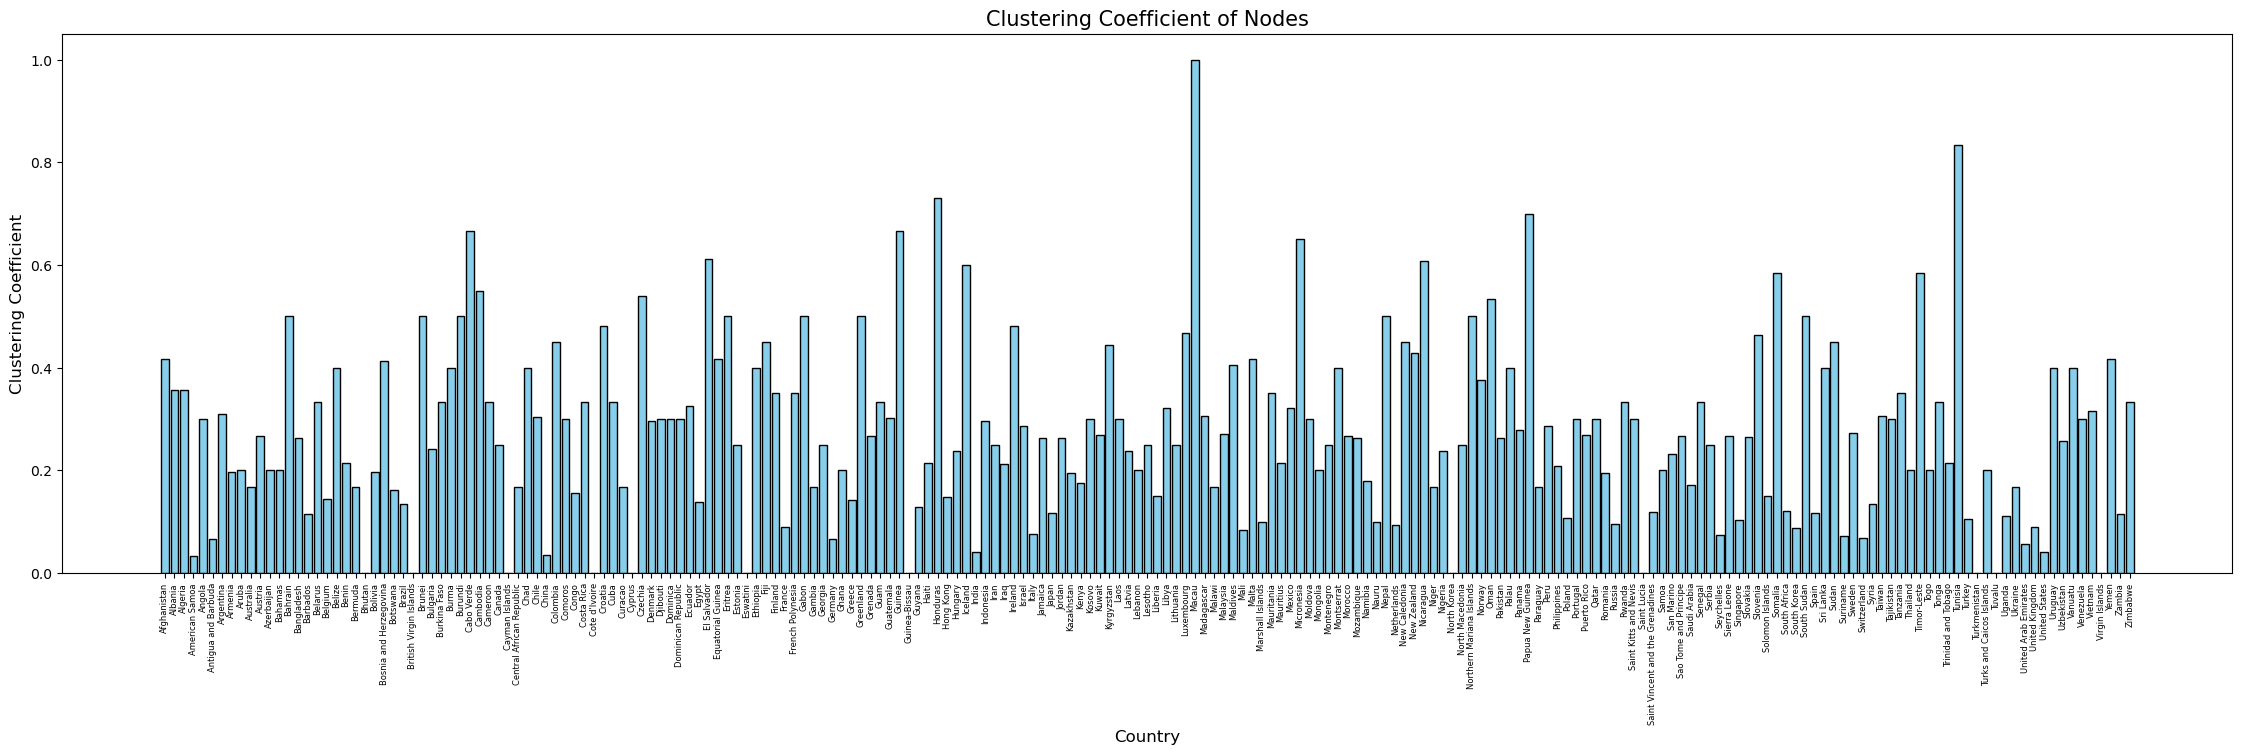

Nodes (Countries) with High Clustering Coefficient (> 0.69):
Macau: 1.0000
Tunisia: 0.8333
Honduras: 0.7308
Papua New Guinea: 0.7000

-----Imports Network-----


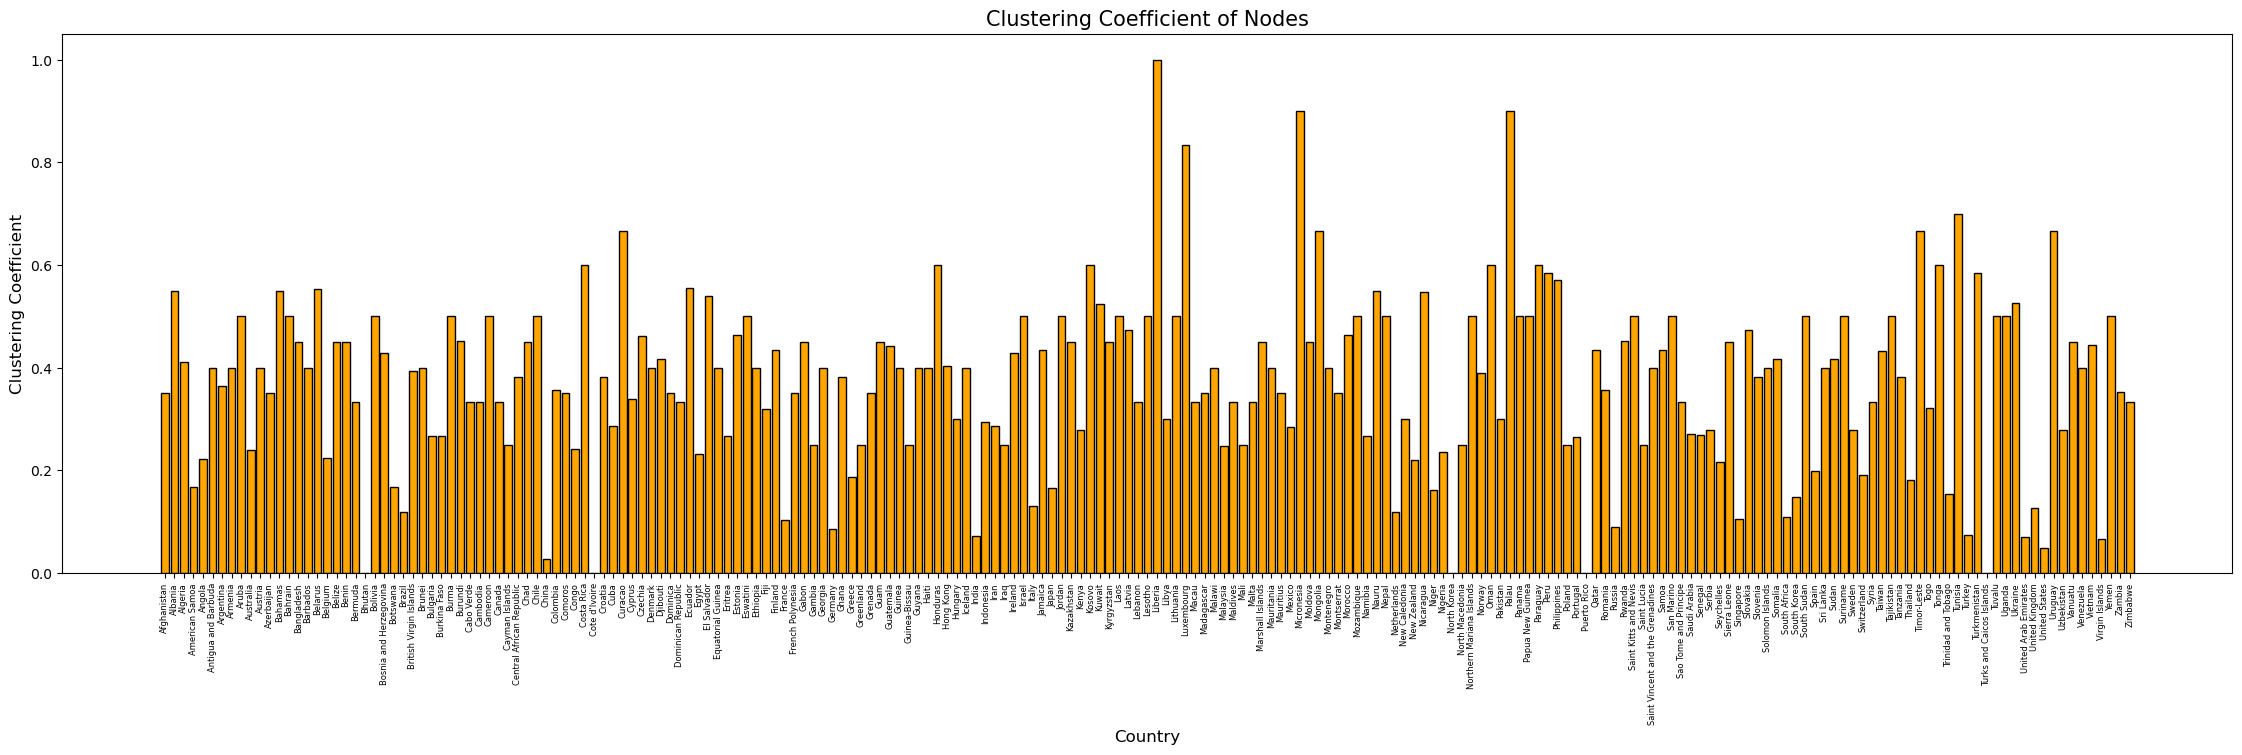

Nodes (Countries) with High Clustering Coefficient (> 0.69):
Liberia: 1.0000
Micronesia: 0.9000
Palau: 0.9000
Luxembourg: 0.8333
Tunisia: 0.7000


In [68]:
clustering_coeffs_export = nx.clustering(G_export)
clustering_coeffs_import = nx.clustering(G_import)
clustering_coeffs_values_export = list(clustering_coeffs_export.values())
clustering_coeffs_values_import = list(clustering_coeffs_import.values())

print("-----Exports Network-----")
high_clustering_nodes_export = centrality(clustering_coeffs_export, type='Clustering Coefficient',threshold=0.69, color='skyblue')
print("\n-----Imports Network-----")
high_clustering_nodes_import = centrality(clustering_coeffs_import, type='Clustering Coefficient',threshold=0.69, color='orange')

### Correlation between Local Clustering Coefficient and Degree Centrality

Is a measure of how these two properties are related across the nodes of a graph. Degree centrality measures the number of connections a node has, while the local clustering coefficient measures the tendency of a node's neighbors to be connected with each other. By examining their correlation, we can gain insights into the structural properties of the graph.

-----Exports Network-----
Pearson correlation coefficient: -0.3323
P-value: 9.9960e-07


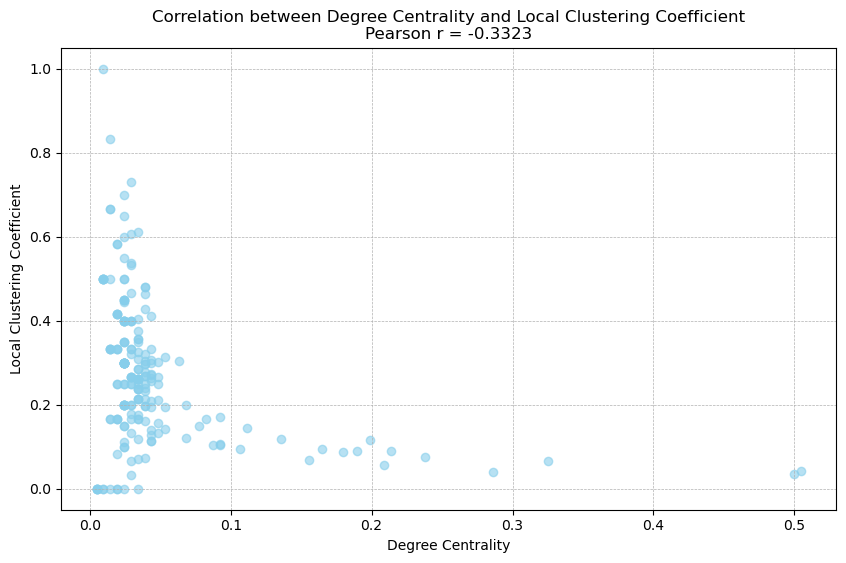


-----Imports Network-----
Pearson correlation coefficient: -0.4171
P-value: 4.0351e-10


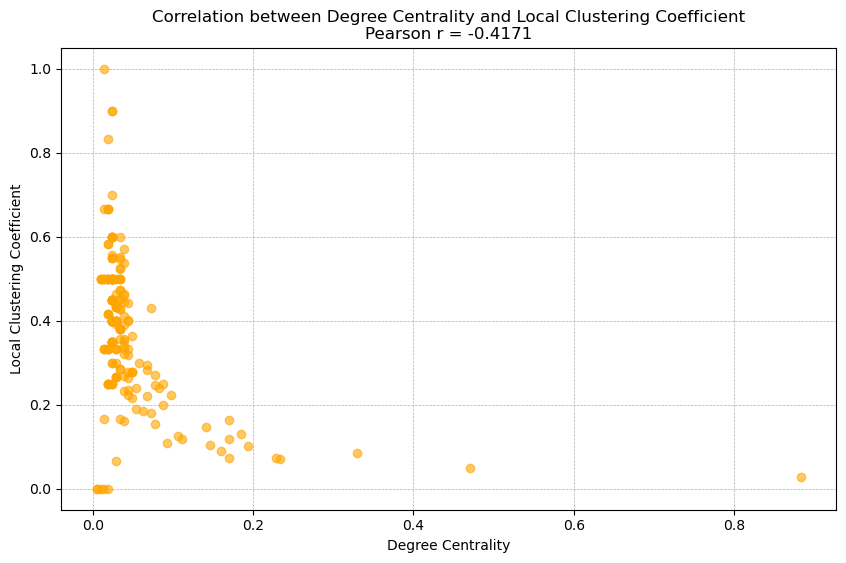

In [71]:
print("-----Exports Network-----")
correlation_export, p_value_export = correlation_cd(clustering_coeffs_values_export, degree_centrality_values_export, color='skyblue')
print("\n-----Imports Network-----")
correlation_import, p_value_import = correlation_cd(clustering_coeffs_values_import, degree_centrality_values_import, color='orange')

## Cliques

Finding cliques in a graph can be useful for understanding the structure and relationships within the graph, such as identifying tightly knit groups of nodes, which might represent communities or highly interconnected subgraphs.

In [74]:
G_undirected_export = G_export.to_undirected()
G_undirected_import = G_import.to_undirected()

cliques_export = list(nx.find_cliques(G_undirected_export))
cliques_import = list(nx.find_cliques(G_undirected_import))

th=6
large_cliques_export = [clique for clique in cliques_export if len(clique) >= th]
large_cliques_import = [clique for clique in cliques_import if len(clique) >= th]

print(f"Clique(s) larger than {th} nodes in the Exports graph:")
for clique in large_cliques_export:
    print(clique)

print(f"Clique(s) larger than {th} nodes in the Imports graph:")
for clique in large_cliques_import:
    print(clique)


largest_clique_export = max(cliques_export, key=len)
largest_clique_import = max(cliques_import, key=len)
print("\nLargest clique in the Exports graph: " + str(largest_clique_export) + " with size: " + str(len(largest_clique_export)))
print("\nLargest clique in the Imports graph: " + str(largest_clique_import) + " with size: " + str(len(largest_clique_import)))

Clique(s) larger than 6 nodes in the Exports graph:
['Bosnia and Herzegovina', 'Italy', 'Germany', 'Croatia', 'Slovenia', 'Austria']
['United Kingdom', 'United States', 'Germany', 'Netherlands', 'Belgium', 'Ireland']
['Italy', 'Germany', 'France', 'United States', 'Libya', 'Spain']
['China', 'Papua New Guinea', 'Japan', 'Australia', 'South Korea', 'Taiwan']
Clique(s) larger than 6 nodes in the Imports graph:
['China', 'Rwanda', 'India', 'United Arab Emirates', 'Kenya', 'Saudi Arabia']
['China', 'United States', 'Argentina', 'Brazil', 'Chile', 'Paraguay']
['China', 'United States', 'Argentina', 'Brazil', 'Chile', 'Bolivia']
['China', 'United States', 'Argentina', 'Brazil', 'Chile', 'Germany']
['China', 'United States', 'Tonga', 'Australia', 'New Zealand', 'Fiji']
['China', 'United States', 'Mexico', 'Guatemala', 'Nicaragua', 'Honduras', 'El Salvador']
['China', 'United States', 'Mexico', 'Guatemala', 'Nicaragua', 'Costa Rica']
['China', 'United States', 'Saudi Arabia', 'Kuwait', 'United

## K-core and core periphery structures

K-core decomposition is used to identify subgraphs within the network that are more densely connected. The k-core of a graph is a maximal subgraph in which each node has at least degree k. By analyzing k-cores, we can identify the most influential and interconnected nodes within the trade network. These core nodes are crucial for understanding the backbone of the trade network, as they often represent countries with strong and diverse trade relationships.

In [78]:
print("-----Exports Network-----")
k_core_nodes_export = kcores(G_noloops_export, 4, 10)
print("\n-----Imports Network-----")
k_core_nodes_import = kcores(G_noloops_import, 4, 10)

-----Exports Network-----

Nodes in the 4-core: ['Afghanistan', 'United Arab Emirates', 'Pakistan', 'India', 'China', 'Albania', 'Italy', 'Spain', 'Germany', 'Greece', 'France', 'Algeria', 'United States', 'United Kingdom', 'South Korea', 'American Samoa', 'Australia', 'Ghana', 'Indonesia', 'Burma', 'Portugal', 'Angola', 'Antigua and Barbuda', 'Suriname', 'Barbados', 'Poland', 'Argentina', 'Brazil', 'Chile', 'Armenia', 'Russia', 'Switzerland', 'Bulgaria', 'Iraq', 'Serbia', 'Netherlands', 'Aruba', 'Malaysia', 'Jordan', 'Venezuela', 'Japan', 'Taiwan', 'Austria', 'Azerbaijan', 'Turkey', 'Israel', 'Bahamas', 'Singapore', 'Thailand', 'Bahrain', 'Saudi Arabia', 'Bangladesh', 'Jamaica', 'Guyana', 'Trinidad and Tobago', 'Ukraine', 'Belgium', 'Belize', 'Guatemala', 'Benin', 'Nigeria', 'Vietnam', 'Luxembourg', 'Bolivia', 'Peru', 'Colombia', 'Bosnia and Herzegovina', 'Croatia', 'Slovenia', 'Botswana', 'South Africa', 'Hong Kong', 'British Virgin Islands', 'Malta', 'Seychelles', 'Brunei', 'Romania

## Assortative mixing by degree

Assortative mixing by degree measures the tendency of nodes to connect to other nodes that are similar in degree. In the context of trade networks, this can indicate whether countries with similar trade volumes tend to trade with each other. High assortative mixing suggests that countries with high trade volumes (high-degree nodes) tend to trade more with other high-volume countries, while low assortative mixing might indicate a more diverse set of trade partners irrespective of trade volume.

In [83]:
assortativity_coefficient_export = nx.degree_assortativity_coefficient(G_export)
assortativity_coefficient_import = nx.degree_assortativity_coefficient(G_import)

print(f"Assortative Mixing by Degree (Exports Network): {assortativity_coefficient_export:.4f}")
print(f"Assortative Mixing by Degree (Imports Network): {assortativity_coefficient_import:.4f}")

Assortative Mixing by Degree (Exports Network): -0.0221
Assortative Mixing by Degree (Imports Network): -0.1176


### Visualize the degree correlations

Degree correlation measures the relationship between a node's degree and the average degree of its neighbors. This can help in understanding how nodes are connected within the network. In trade networks, it helps to analyze whether countries with many trade connections (high-degree nodes) tend to be connected to other well-connected countries or to less connected countries. This information can reveal the structural properties of the trade network, such as the presence of hubs or clusters.

-----Exports Network-----


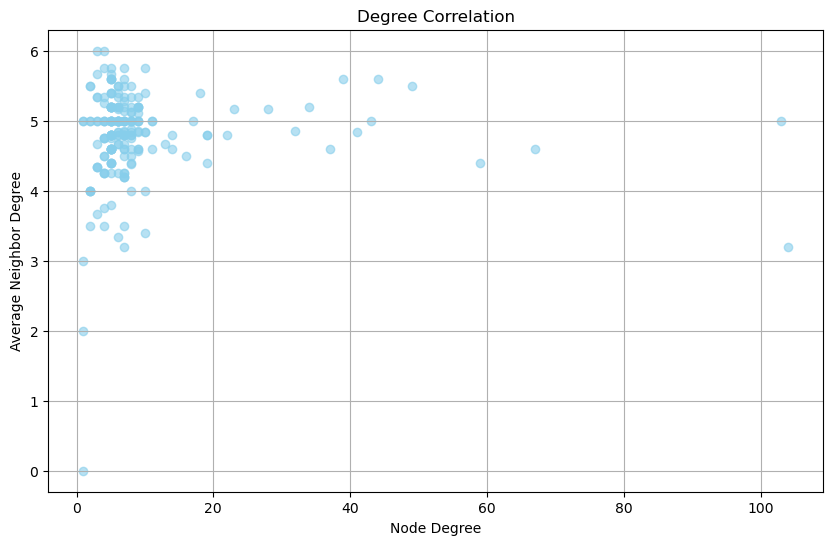


-----Imports Network-----


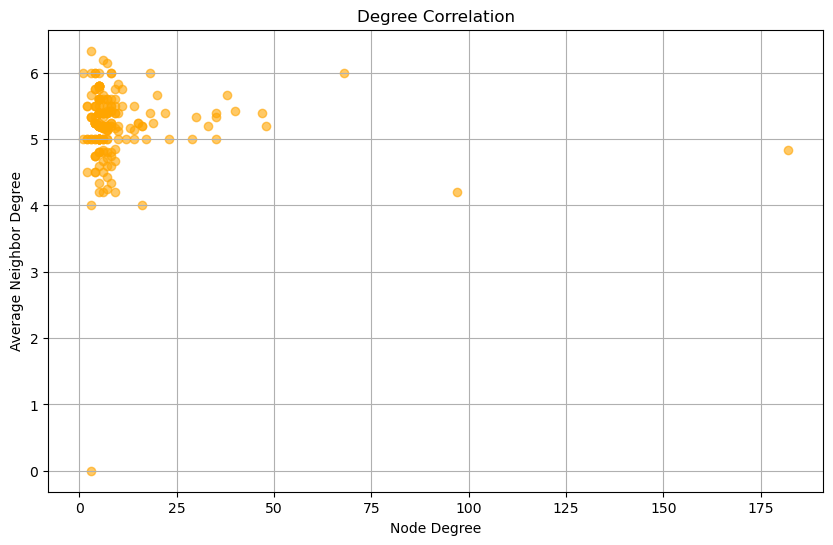

In [90]:
print("-----Exports Network-----")
deg_cor(G_export)
print("\n-----Imports Network-----")
deg_cor(G_import, color='orange')

## Density

Graph density is a measure of how many edges are present in the graph compared to the maximum possible number of edges. It gives a sense of how "dense" or "sparse" the network is. In the context of trade networks, density indicates the overall connectivity among countries. A denser network suggests that there are more trade relationships between countries, indicating a more interconnected and potentially robust global trade system.

In [95]:
graph_density_export = nx.density(G_export)
graph_density_import = nx.density(G_import)

print(f"Graph Density (Exports): {graph_density_export:.4f}")
print(f"Graph Density (Imports): {graph_density_import:.4f}")

Graph Density (Exports): 0.0228
Graph Density (Imports): 0.0235


# Attributes Analysis and Comparisons

In [97]:
# Extracting data for histograms
gdp_data = extract_node_attributes(G_exports, 'GDP')
exports_dollars_data = extract_node_attributes(G_exports, 'Exports $')
imports_dollars_data = extract_node_attributes(G_imports, 'Imports $')
exports_gdp_percentage_data = extract_node_attributes(G_exports, 'Exports GDP%')
imports_gdp_percentage_data = extract_node_attributes(G_imports, 'Imports GDP%')

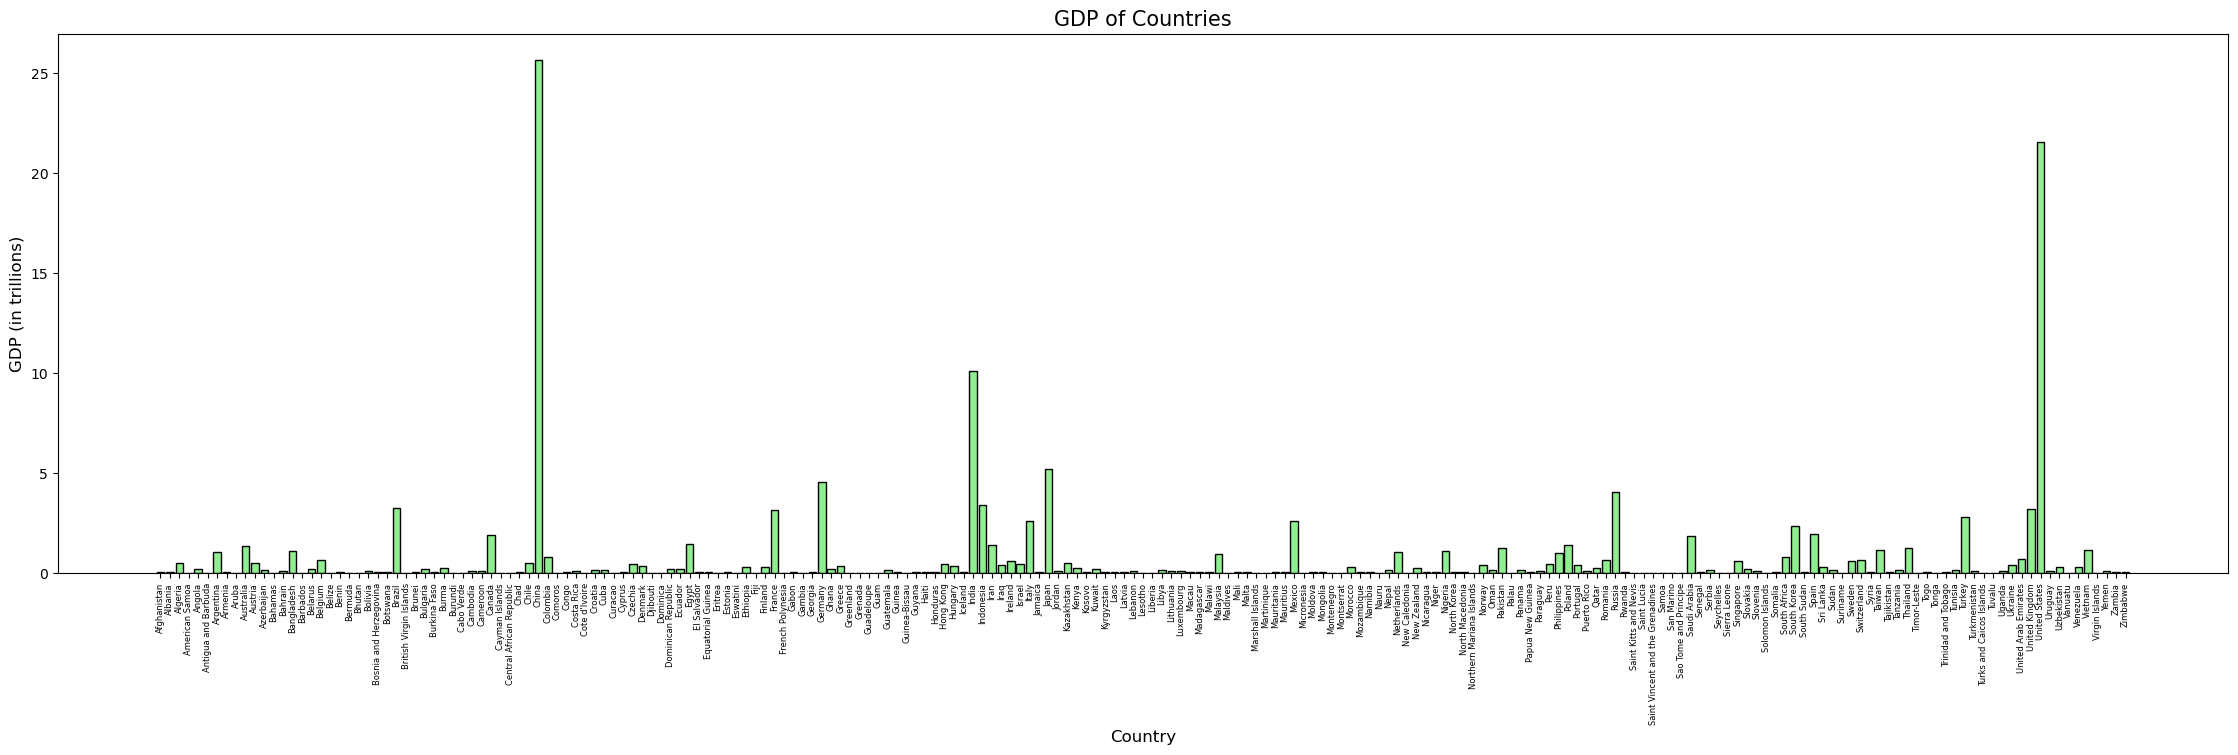

In [99]:
plot_attributes(gdp_data, 'GDP of Countries', 'Country', 'GDP (in trillions)', 'lightgreen')

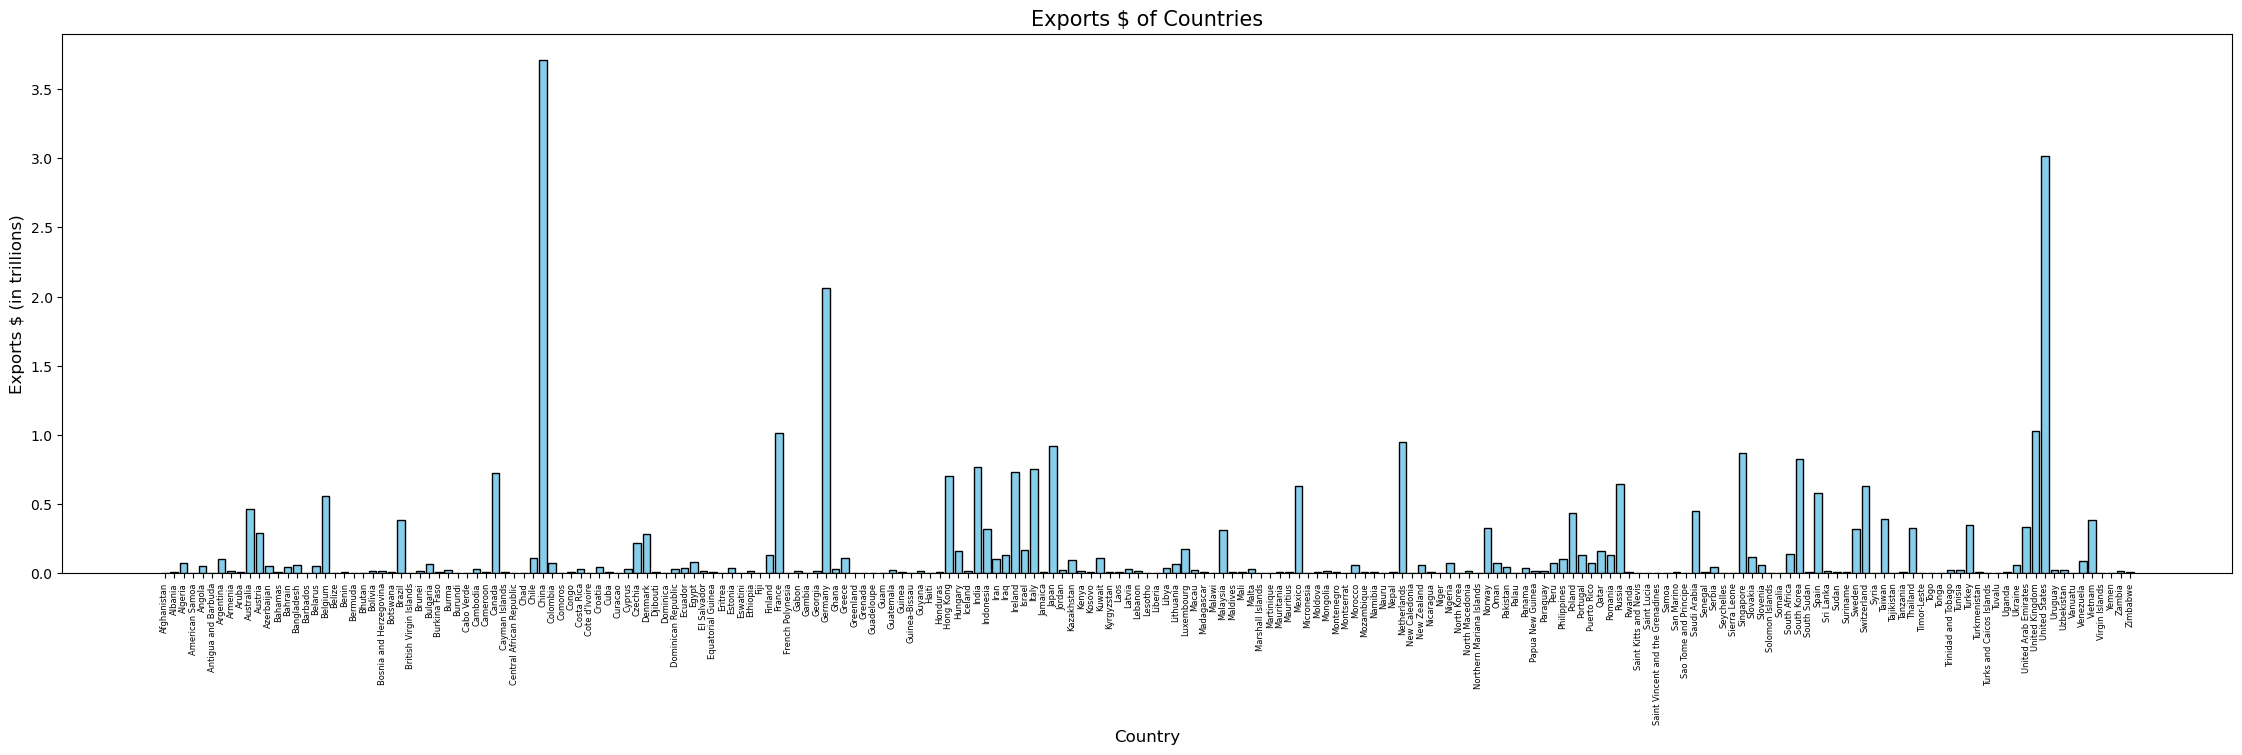

In [100]:
plot_attributes(exports_dollars_data, 'Exports $ of Countries', 'Country', 'Exports $ (in trillions)')

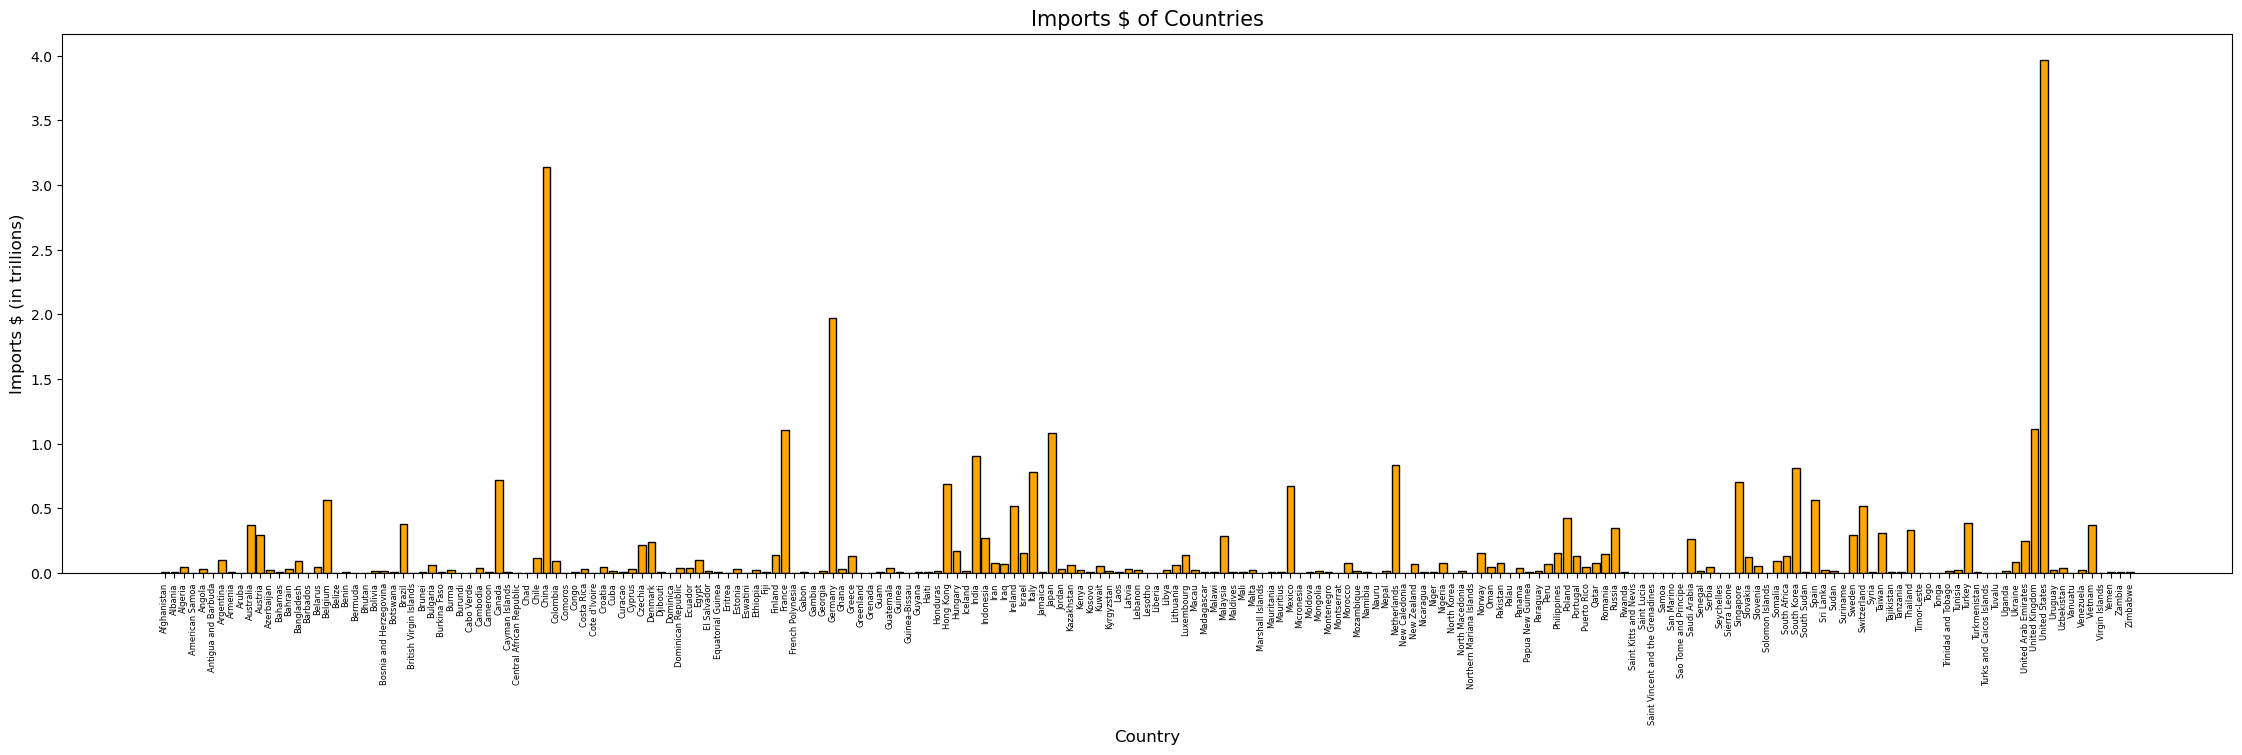

In [104]:
plot_attributes(imports_dollars_data, 'Imports $ of Countries', 'Country', 'Imports $ (in trillions)', 'orange')

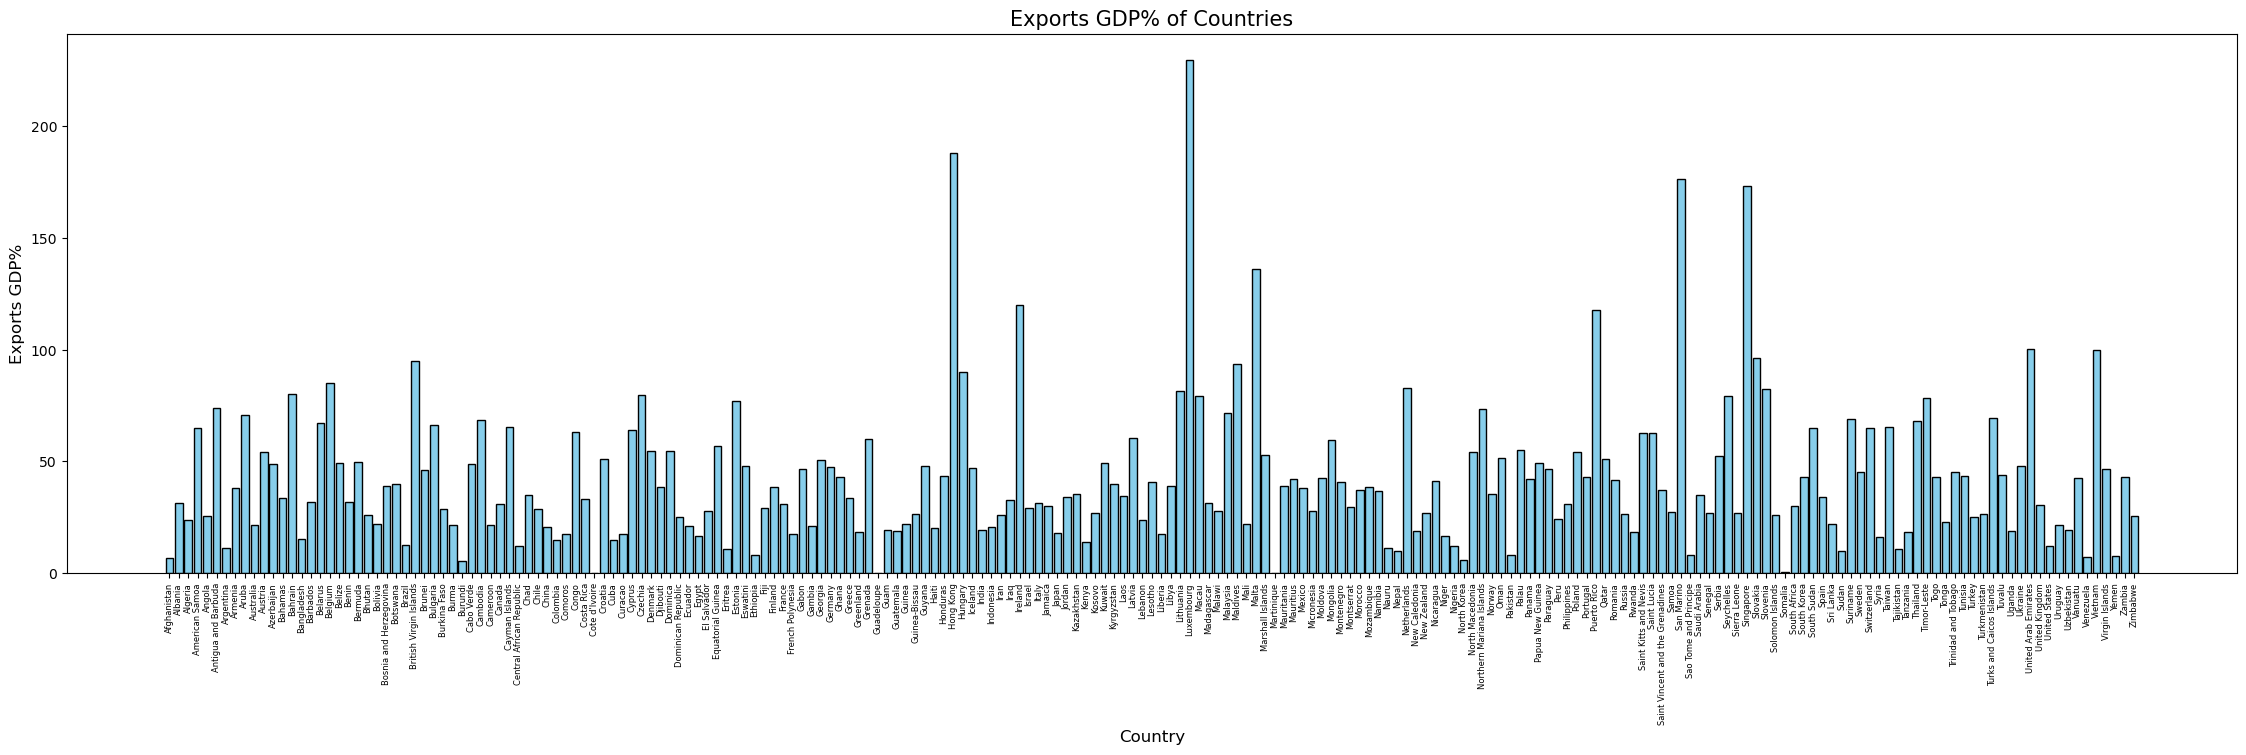

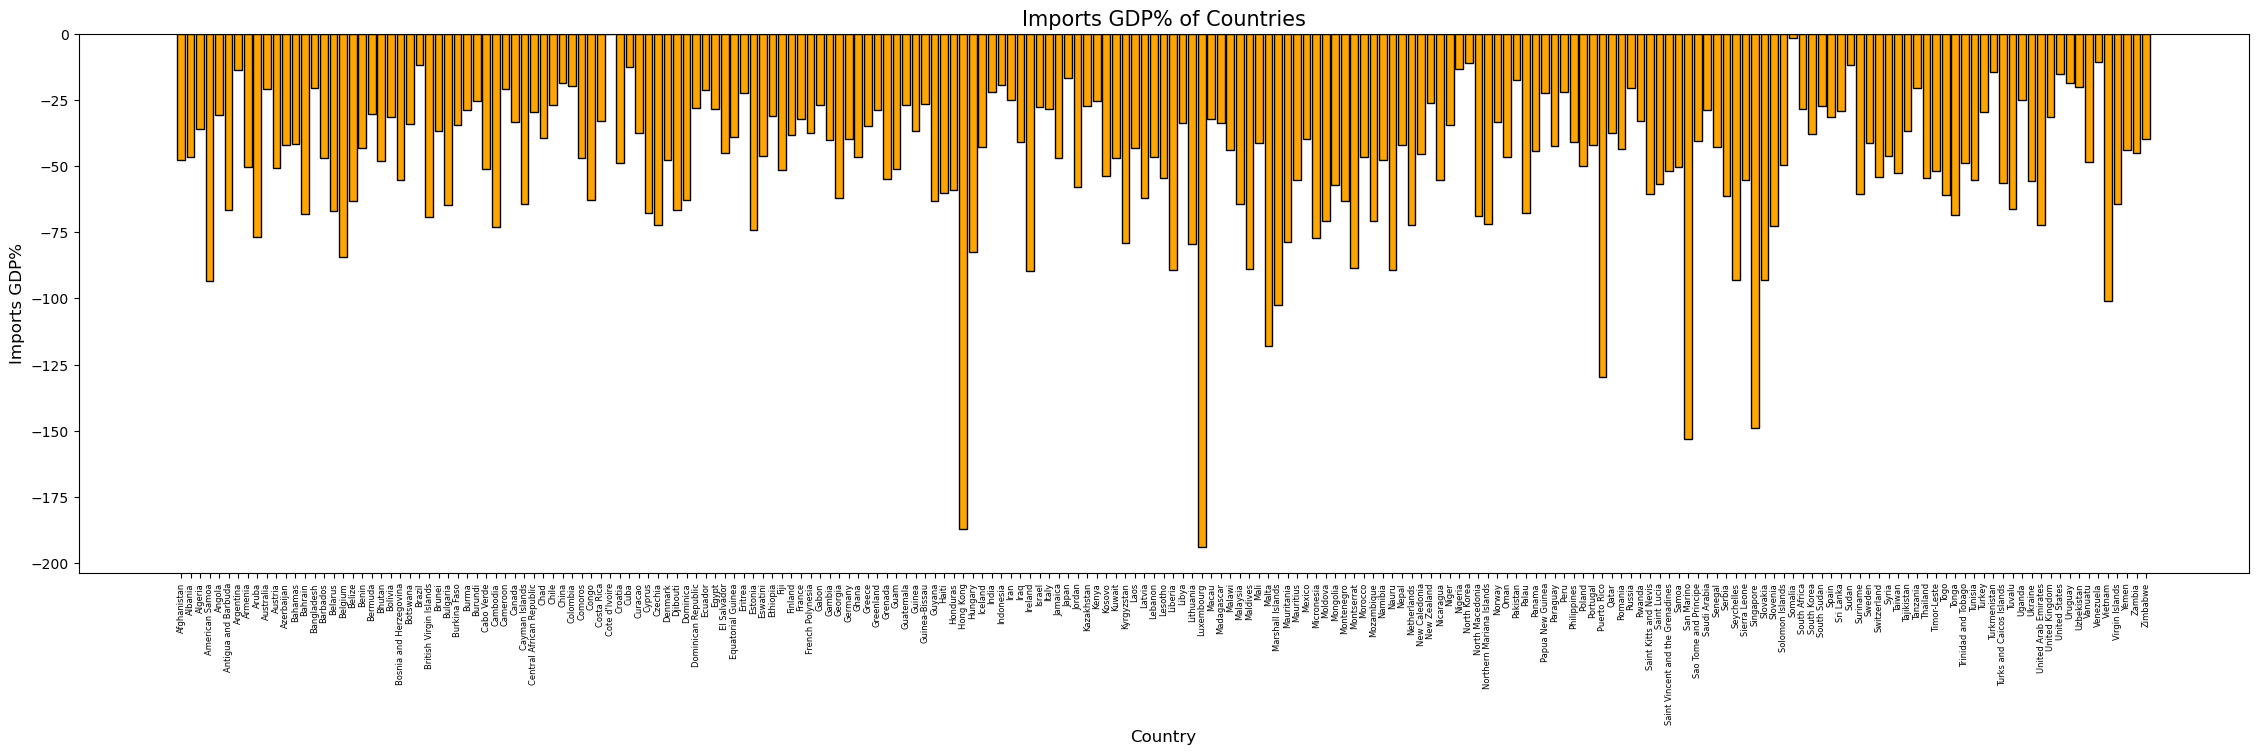

In [106]:
exports_gdp_percentage_data = {k: float(v) for k, v in exports_gdp_percentage_data.items()}
imports_gdp_percentage_data = {k: float(v) for k, v in imports_gdp_percentage_data.items()}
plot_attributes(exports_gdp_percentage_data, 'Exports GDP% of Countries', 'Country', 'Exports GDP%', 'skyblue')
plot_attributes(imports_gdp_percentage_data, 'Imports GDP% of Countries', 'Country', 'Imports GDP%', 'orange')

## Gephi CSV Exports

In [108]:
# Export nodes (attributes) to CSV
def export_csv_nodes(G, degree_centrality, eigenvector_centrality,betweenness_centrality, closeness_centrality, pagerank, clustering_coeffs, filename= 'measures.csv'):
    with open(filename, 'w', newline='') as csvfile:
        fieldnames = ['Node', 'Degree', 'Eigenvector', 'Betweenness', 'Closeness', 'PageRank', 'ClusteringCoefficient']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for node in G.nodes():
            writer.writerow({
                'Node': node, 
                'Degree': degree_centrality[node],
                'Eigenvector': eigenvector_centrality[node],
                'Betweenness': betweenness_centrality[node],
                'Closeness': closeness_centrality[node],
                'PageRank': pagerank[node], 
                'ClusteringCoefficient': clustering_coeffs[node],
            })
    print(f"Nodes CSV has been saved as {filename}")

# Export edges (structure) to CSV
def export_csv_edges(G, filename):
    with open(filename, 'w', newline='') as csvfile:
        fieldnames = ['Source', 'Target', 'Weight']  # Add more fields as per your edge attributes
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for edge in G.edges(data=True):
            writer.writerow({
                'Source': edge[0],
                'Target': edge[1],
                'Weight': edge[2]['weight'] if 'weight' in edge[2] else 1,  # Example for edge weight
                # Add more attributes as needed
            })

    print(f"Edges CSV has been saved as {filename}")

export_csv_nodes(G_export, degree_centrality_export, eigenvector_centrality_export, betweenness_centrality_export, closeness_centrality_export, pagerank_export, clustering_coeffs_export, filename= 'nodes_export.csv')
export_csv_nodes(G_import, degree_centrality_import, eigenvector_centrality_import, betweenness_centrality_import, closeness_centrality_import, pagerank_import, clustering_coeffs_import, filename= 'nodes_import.csv')
export_csv_edges(G_export, 'edges_export.csv')
export_csv_edges(G_import, 'edges_import.csv')


Nodes CSV has been saved as nodes_export.csv
Nodes CSV has been saved as nodes_import.csv
Edges CSV has been saved as edges_export.csv
Edges CSV has been saved as edges_import.csv
